## Libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing 

from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.utils.plotting import plot_series

# from fbprophet import Prophet
# from prophet.diagnostics import cross_validation, performance_metrics
# from prophet.plot import plot_yearly, add_changepoints_to_plot

## Data

### Preparation

In [4]:
df = pd.read_csv('data/rm-yields-data.csv', header=0, index_col=0, parse_dates=True).squeeze()
canola = df['Canola']
canola.drop(canola.index[:33], inplace=True)

print(canola)

#print(canola)C:\Users\maris\xai-for-time-series-forecasting

Year
1971-01-01    18.0
1972-01-01    18.0
1973-01-01    20.0
1974-01-01    16.0
1975-01-01    15.0
              ... 
2018-01-01    39.3
2019-01-01    46.1
2020-01-01    40.9
2021-01-01    23.9
2022-01-01    44.4
Name: Canola, Length: 15445, dtype: float64


In [5]:
#read dataframe 
canola_2 = df = pd.read_csv('data/rm-yields-data.csv', header=0, index_col=0, parse_dates=True)
canola_small = canola_2.iloc[:, [0, 2]].copy()

#cut of first 33 observations (NAs)
canola_small.drop(canola_small.index[:33], inplace=True)

#filter out every observation that contains NAs
canola_filtered = canola_small.groupby('RM').filter(lambda group: not group['Canola'].isnull().any())

# how may districts? 148
num_districts = canola_filtered.groupby('RM').ngroups

### Visualization

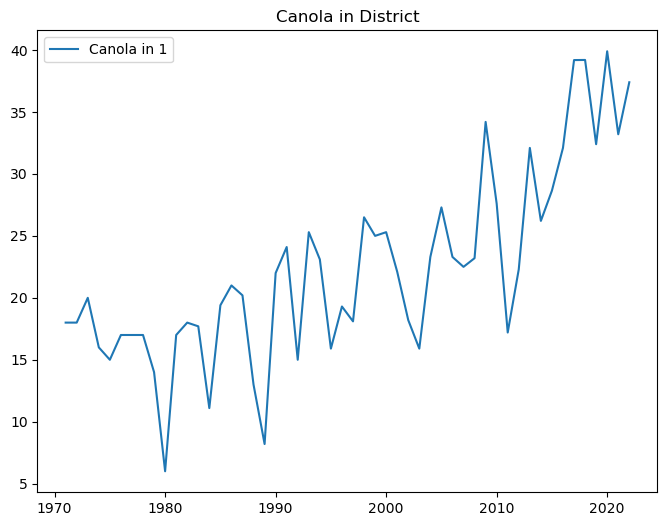

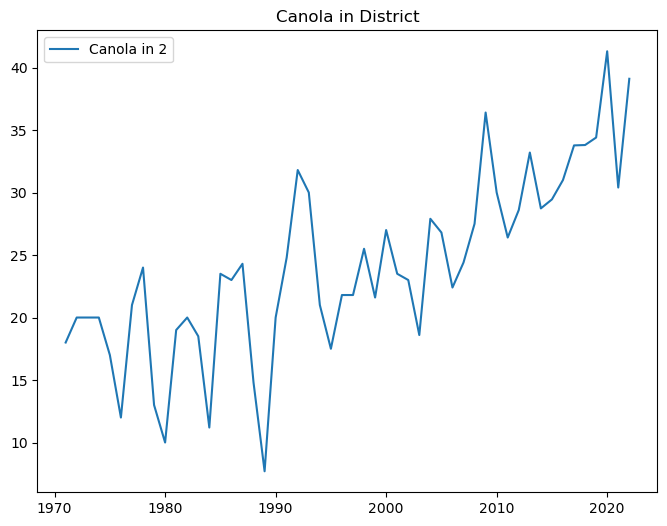

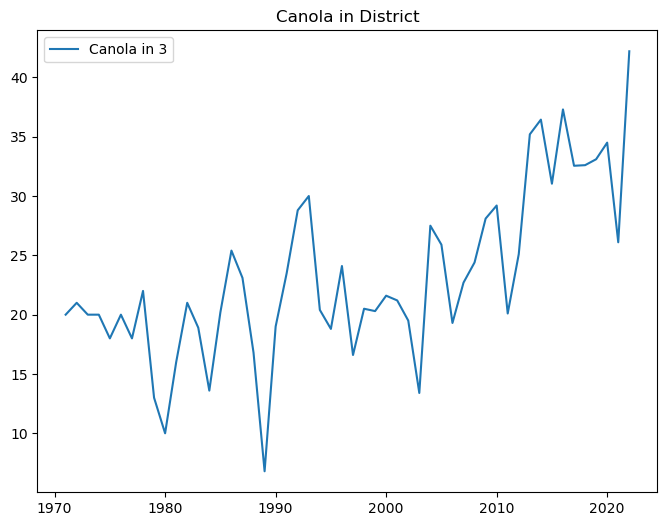

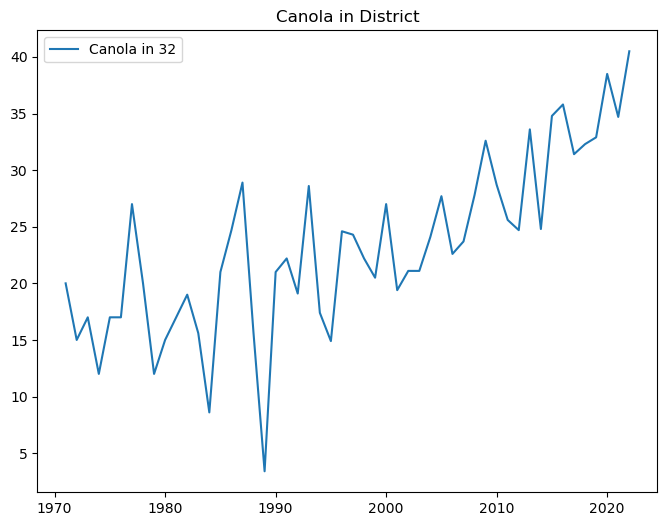

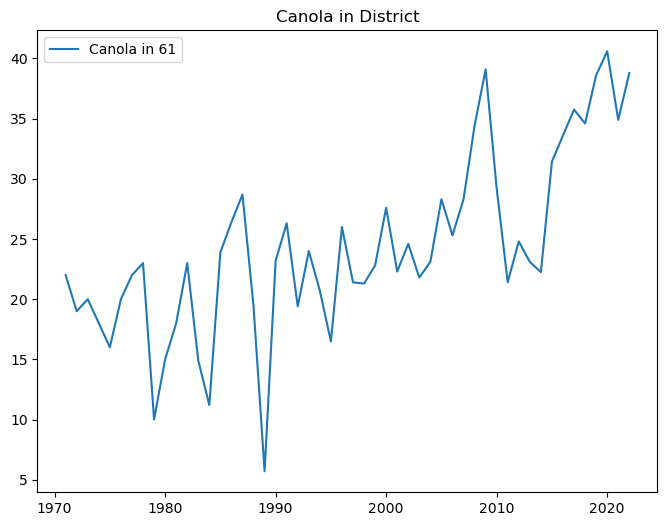

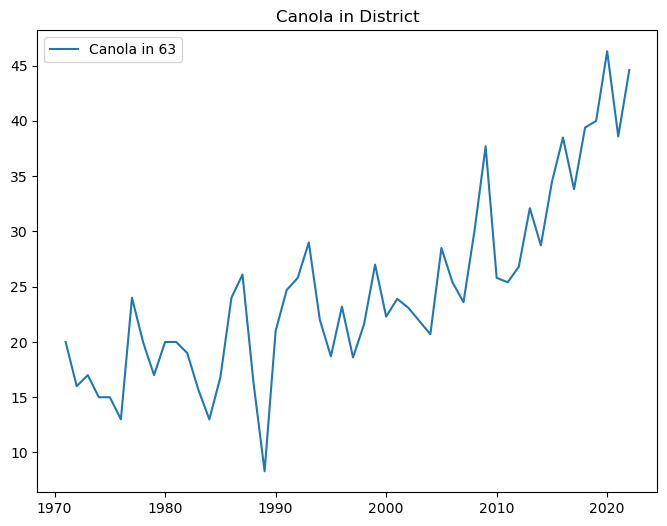

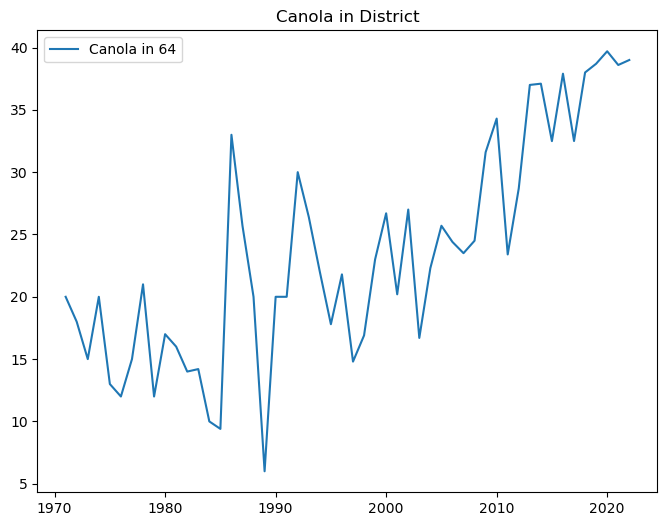

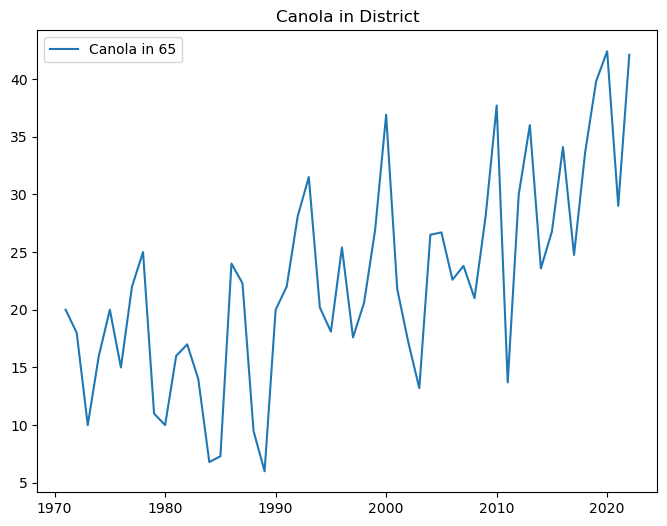

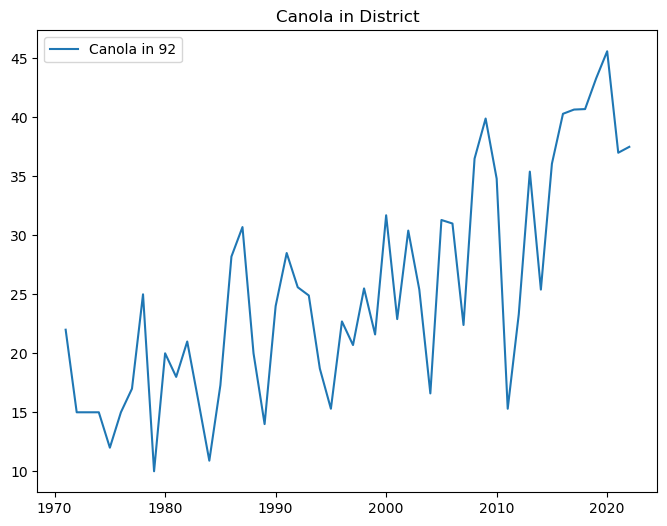

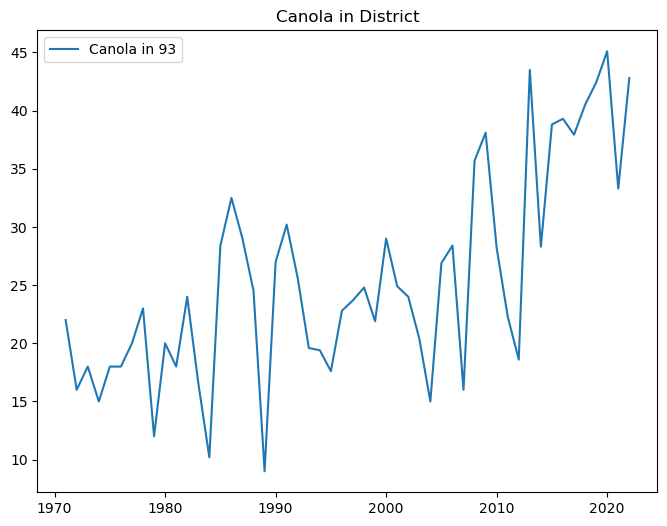

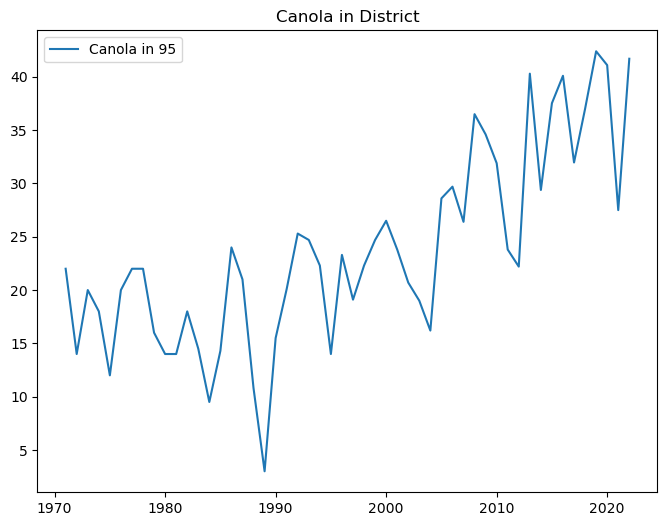

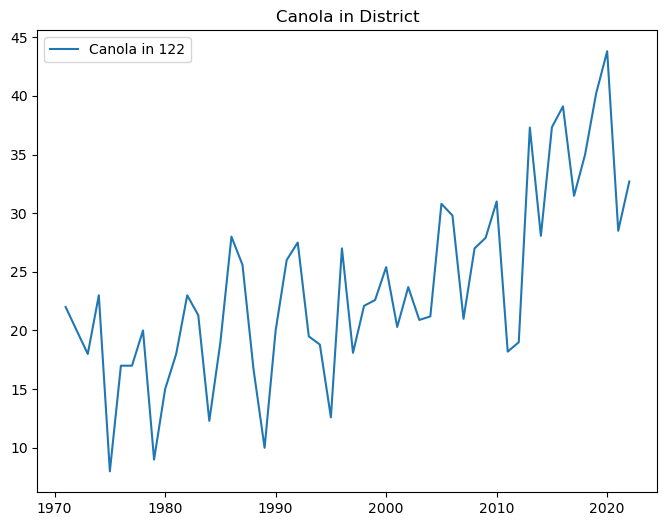

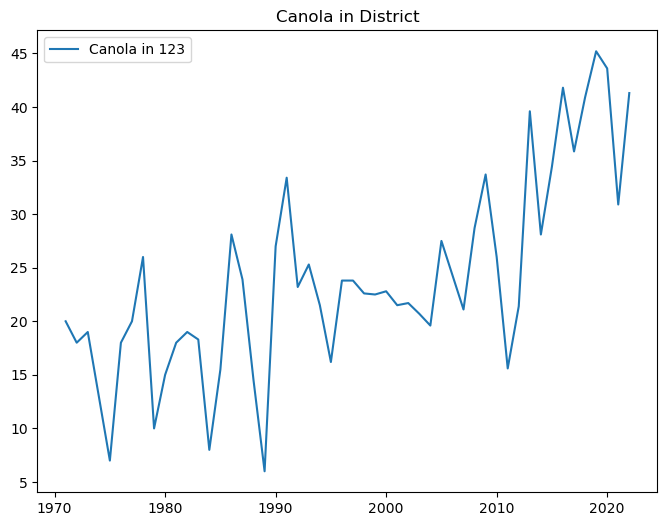

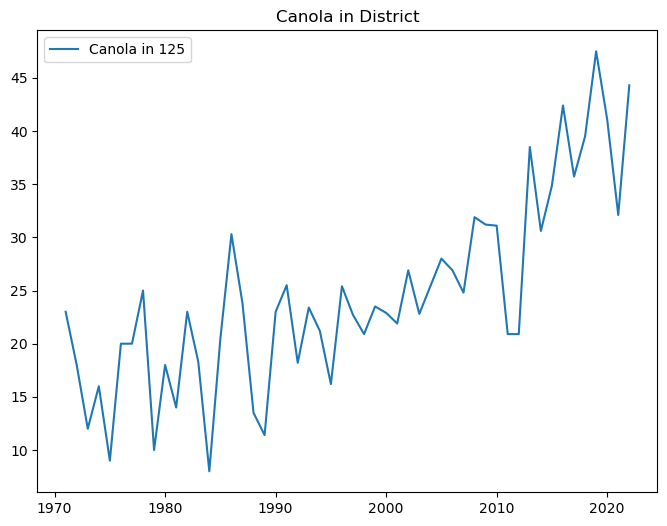

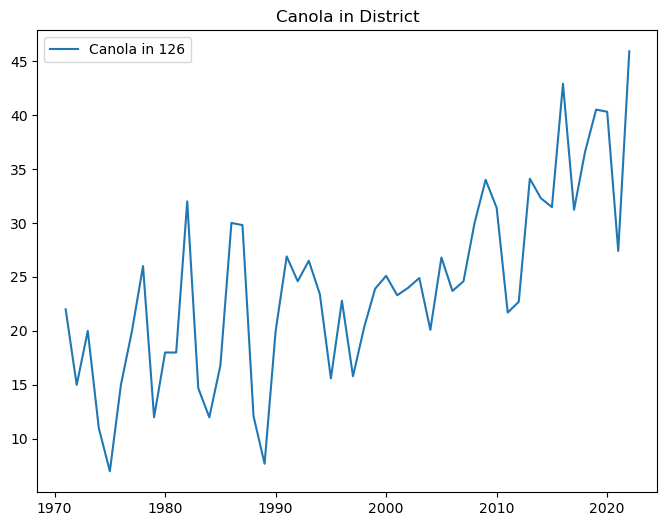

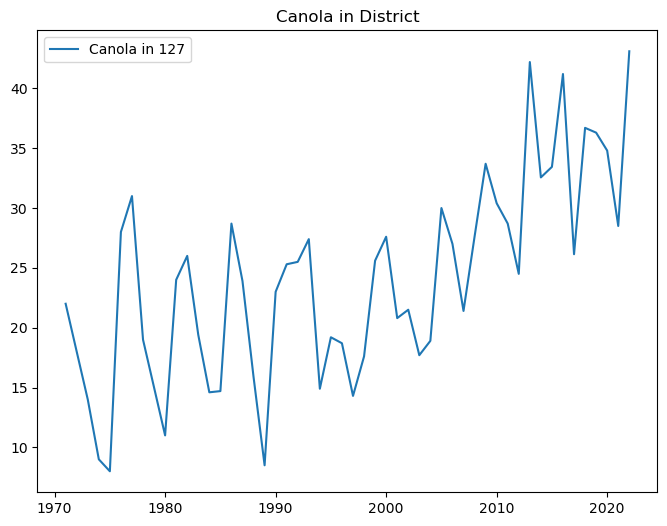

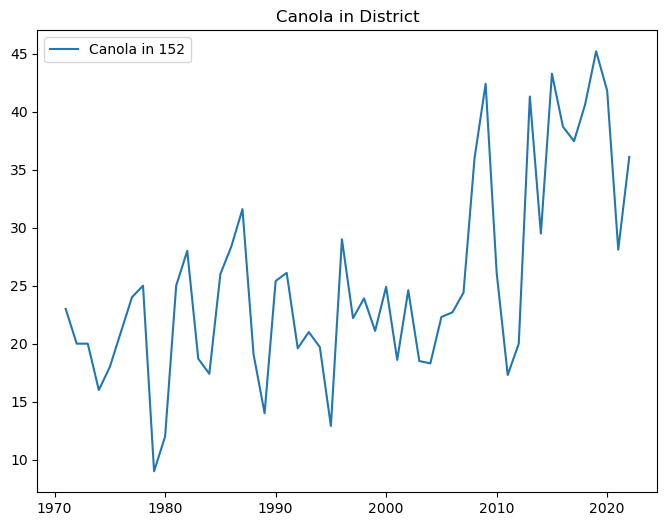

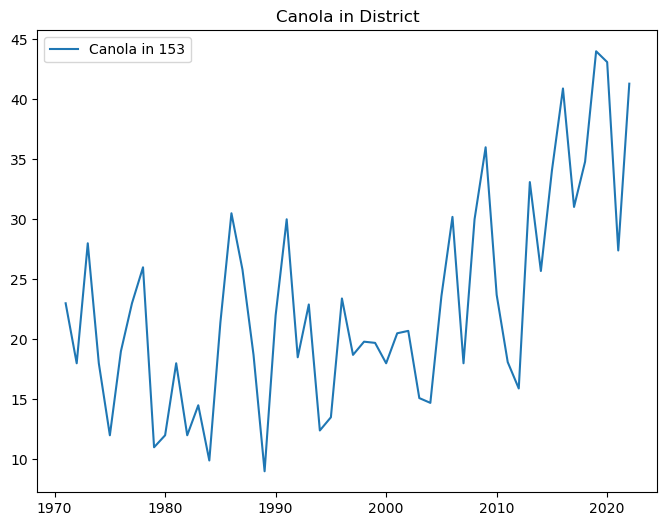

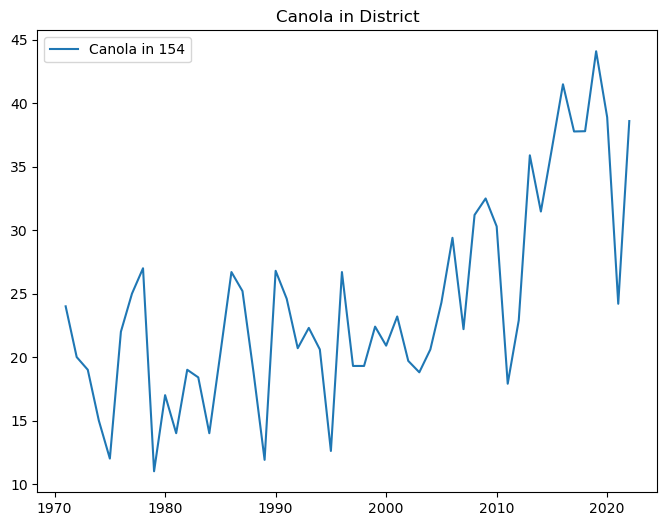

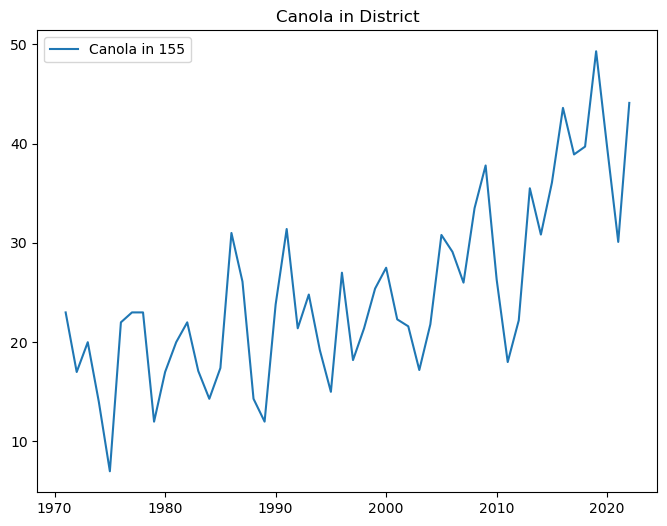

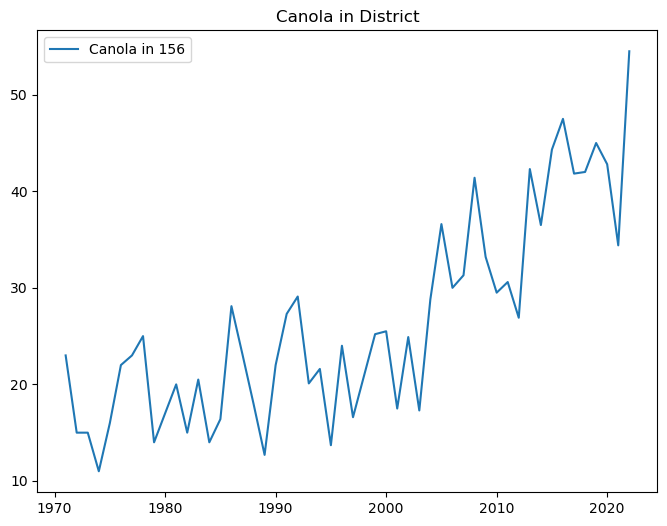

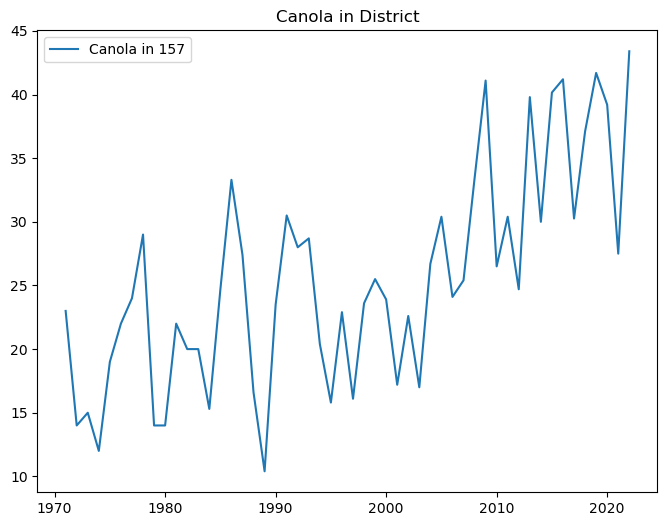

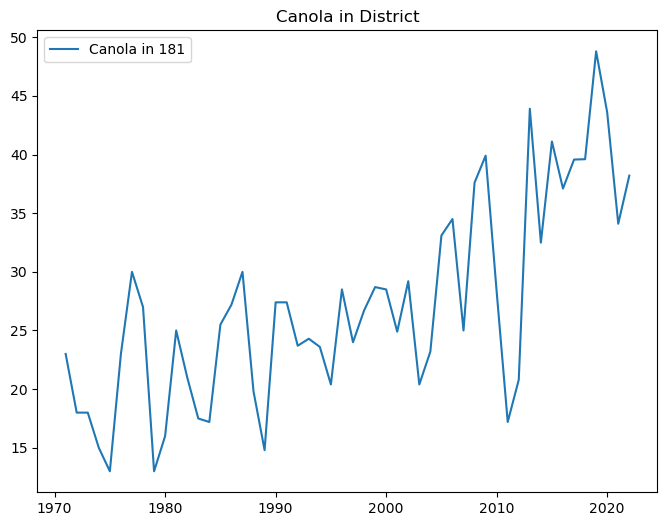

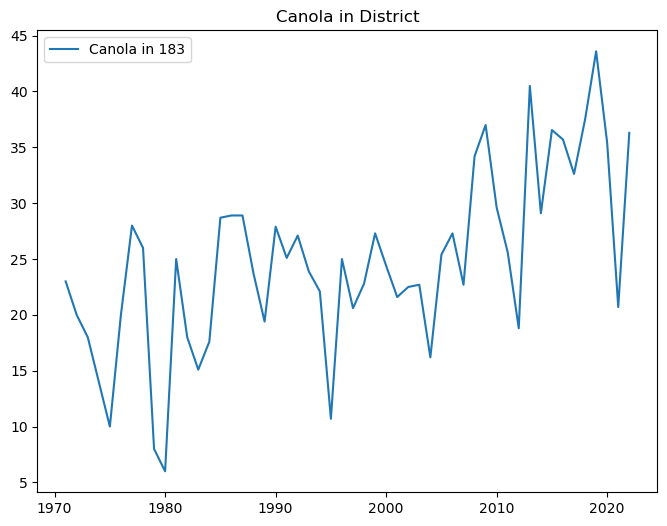

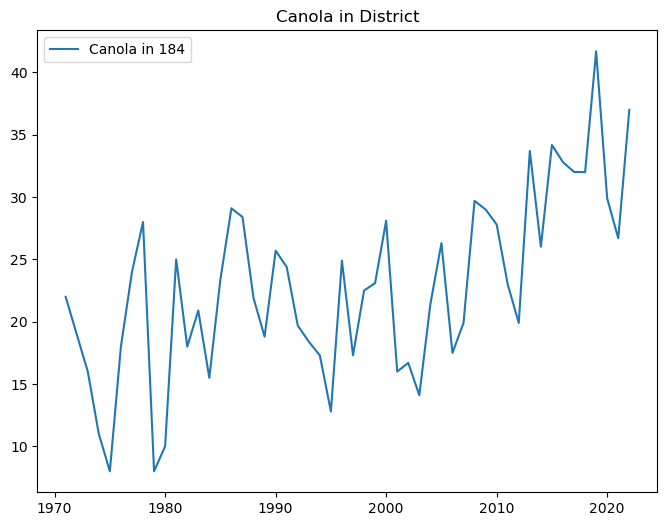

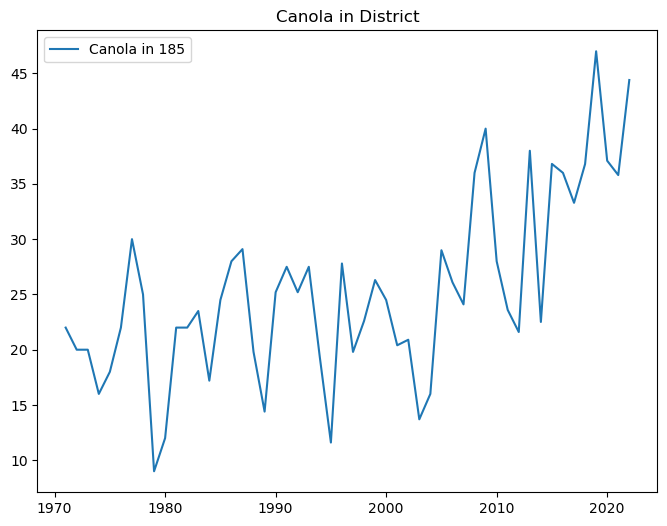

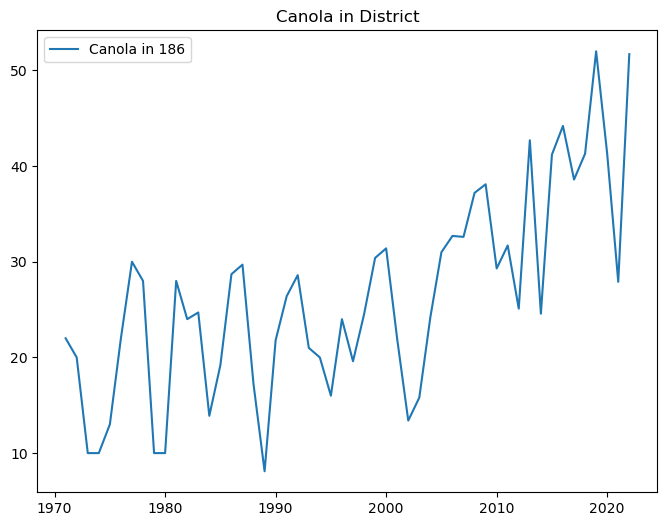

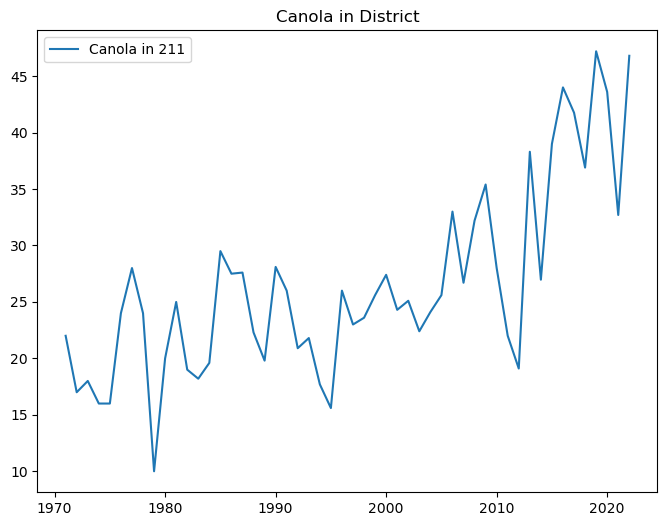

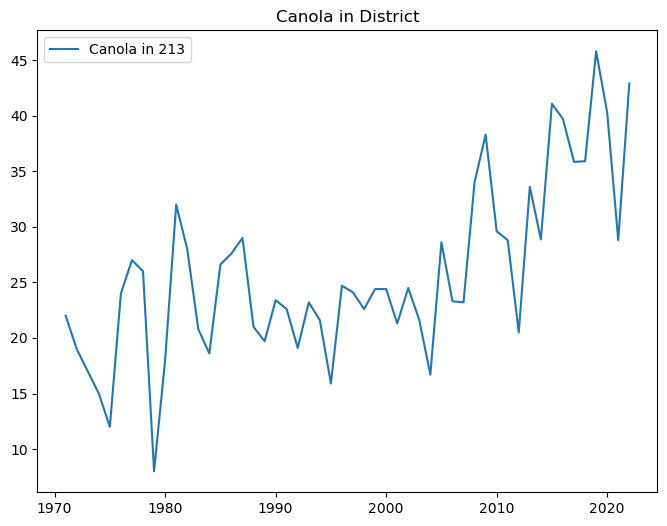

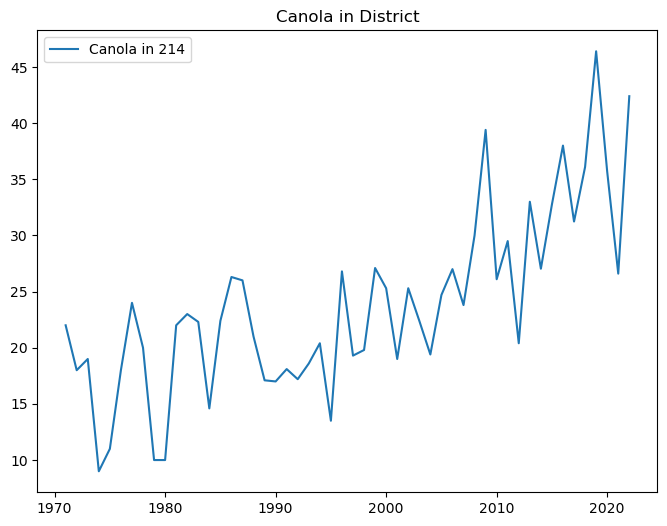

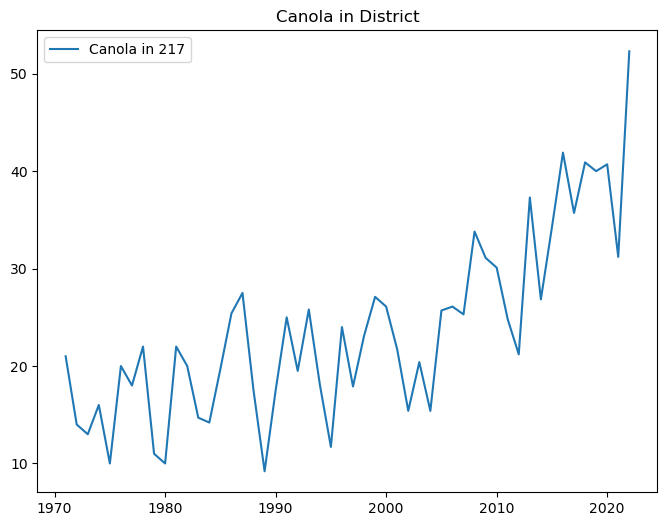

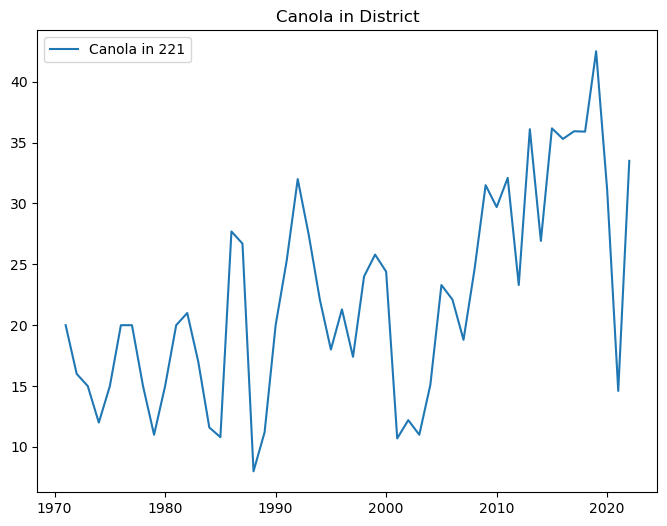

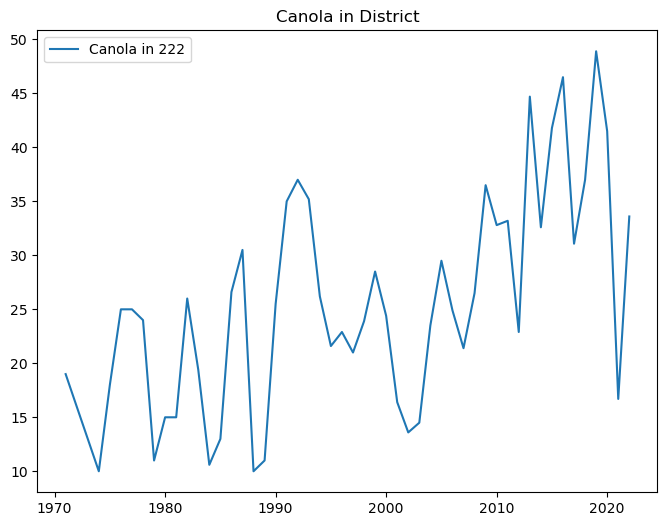

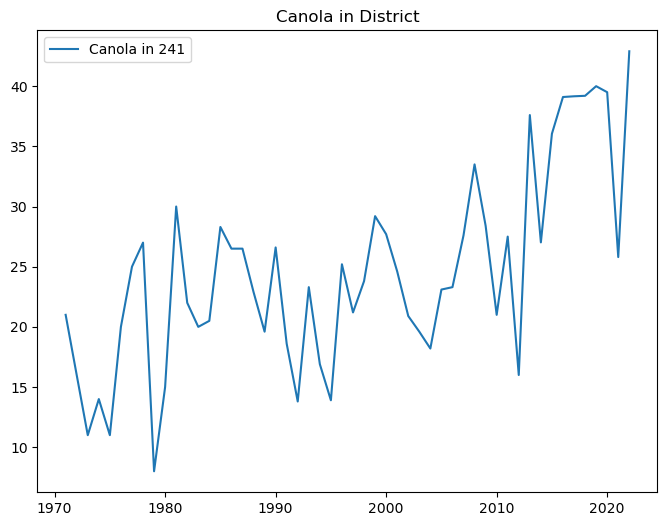

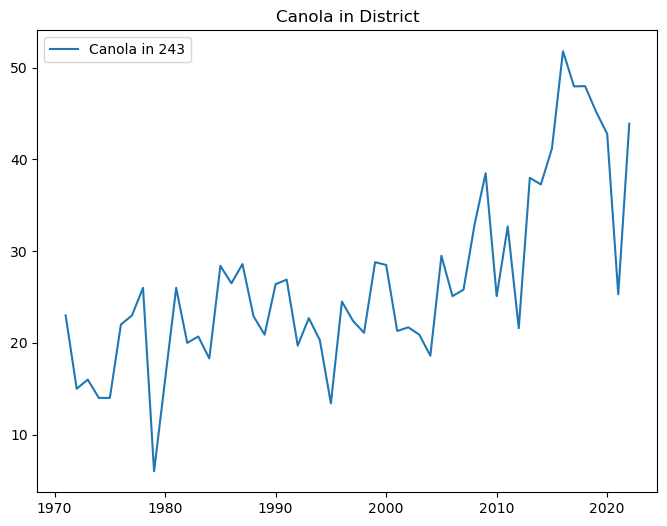

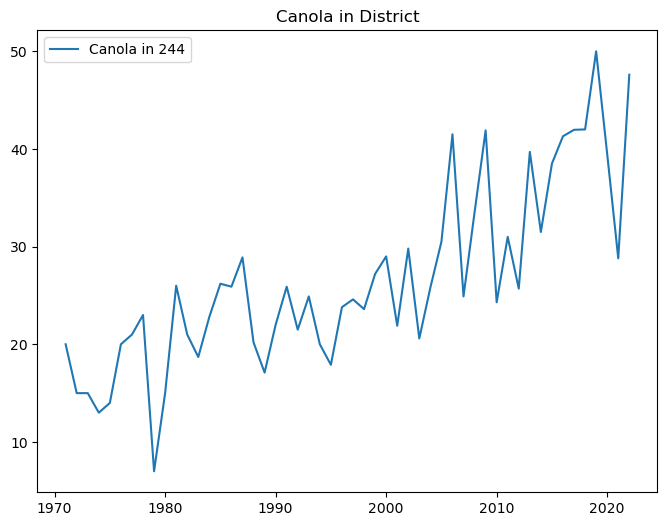

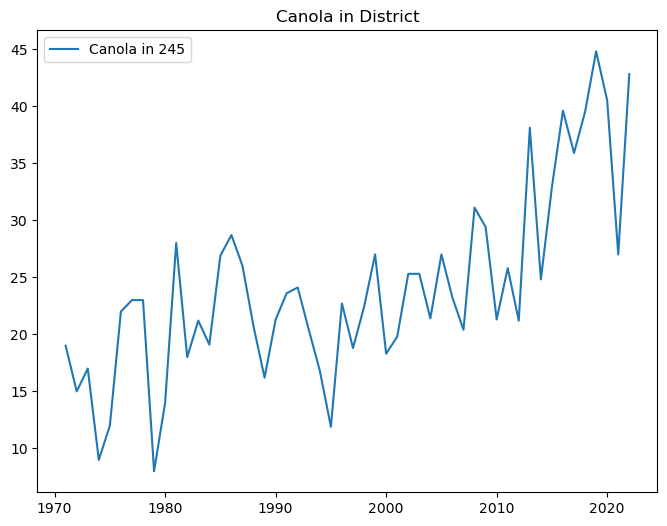

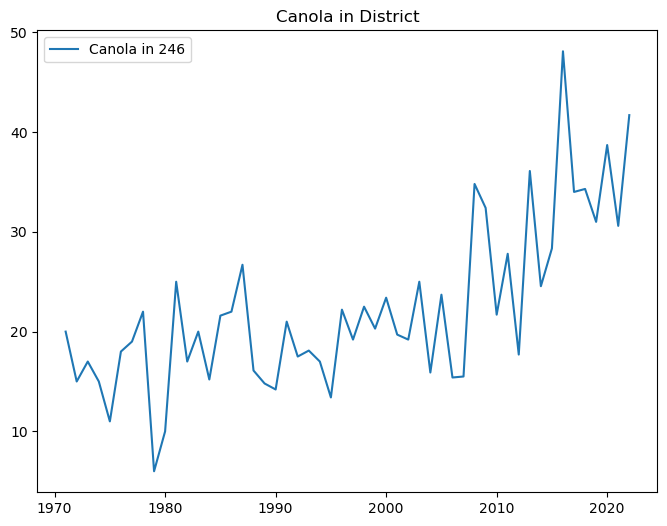

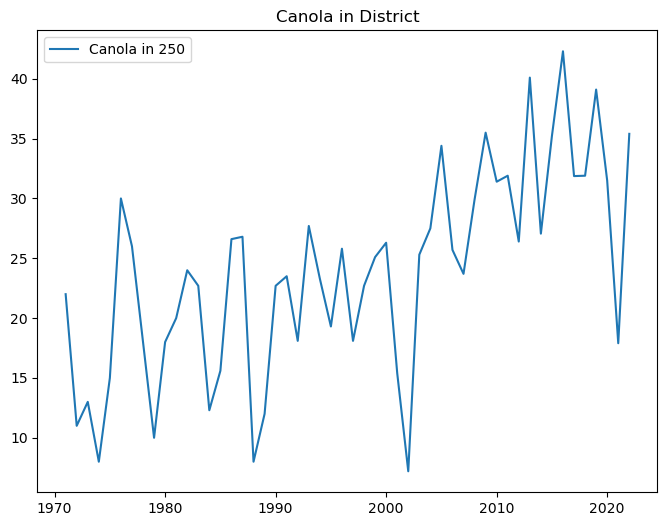

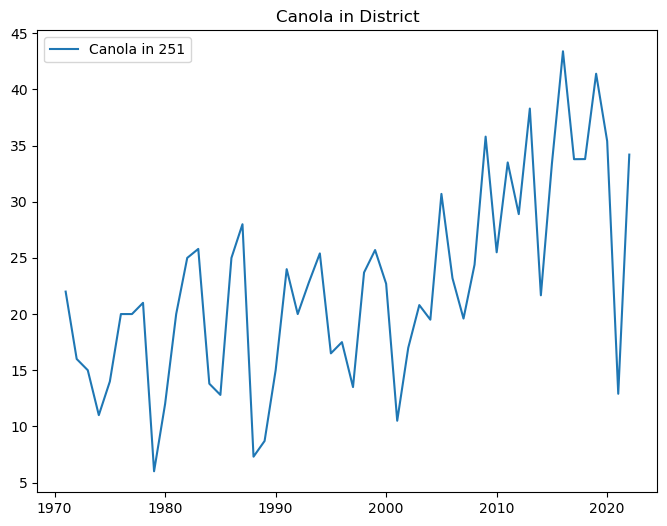

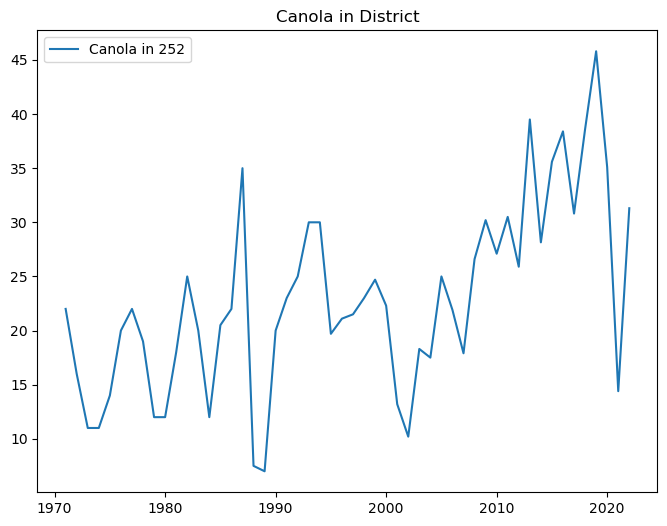

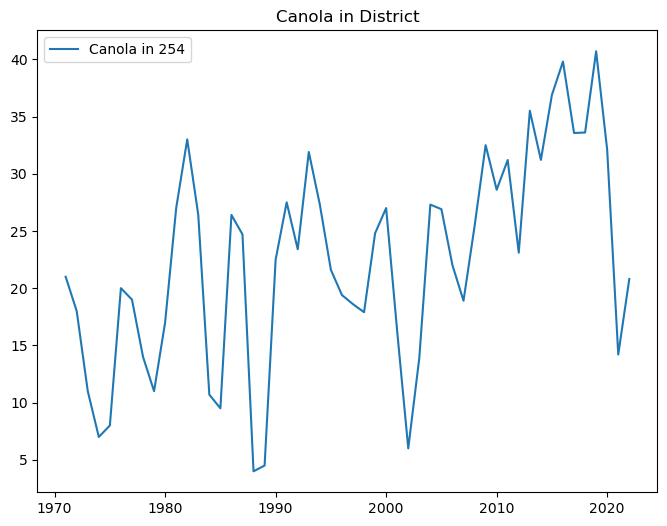

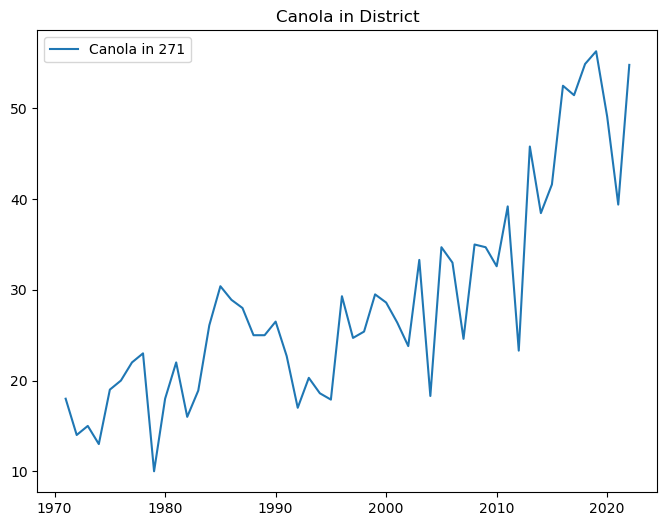

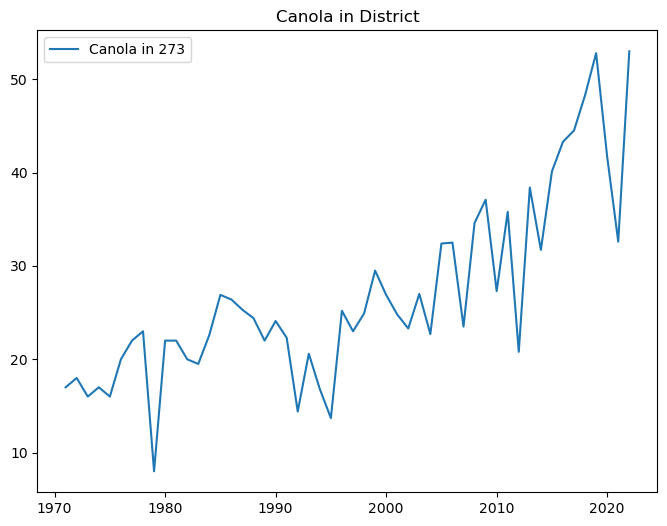

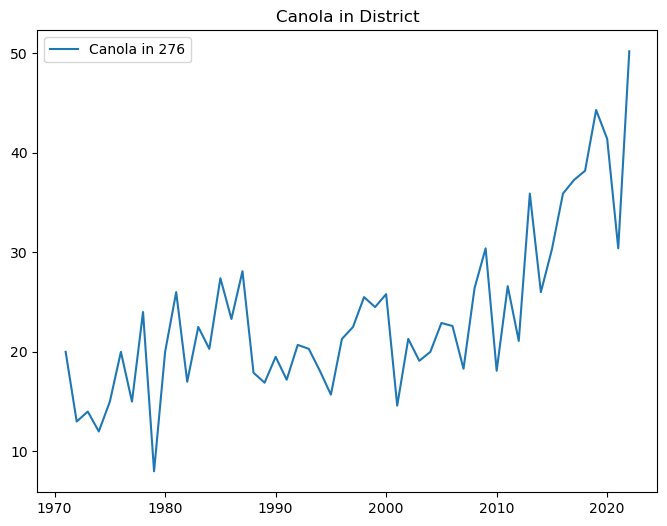

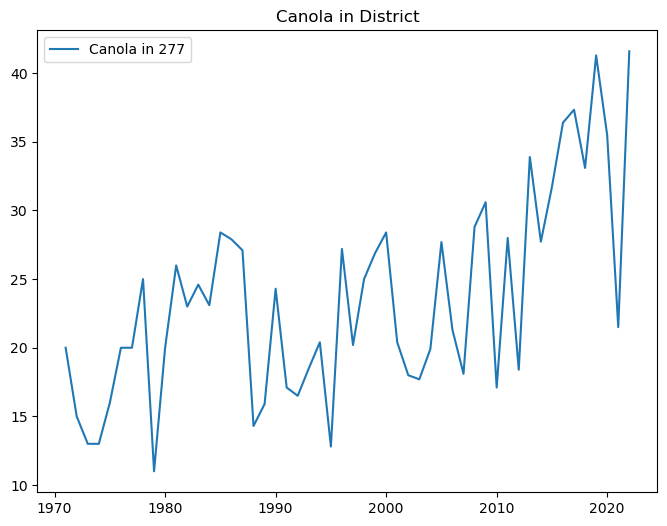

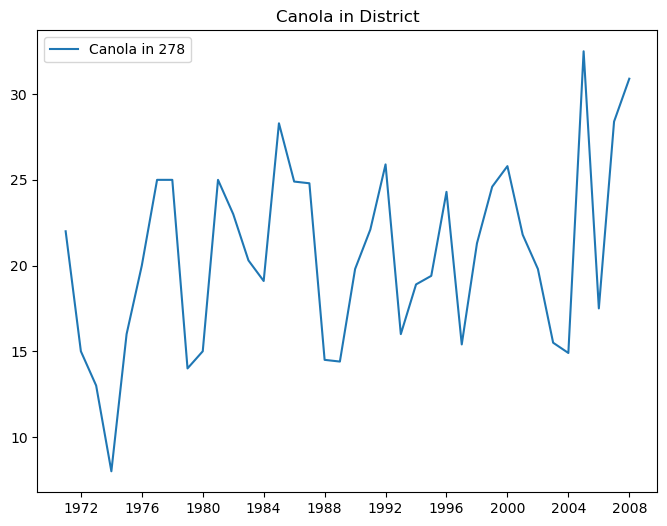

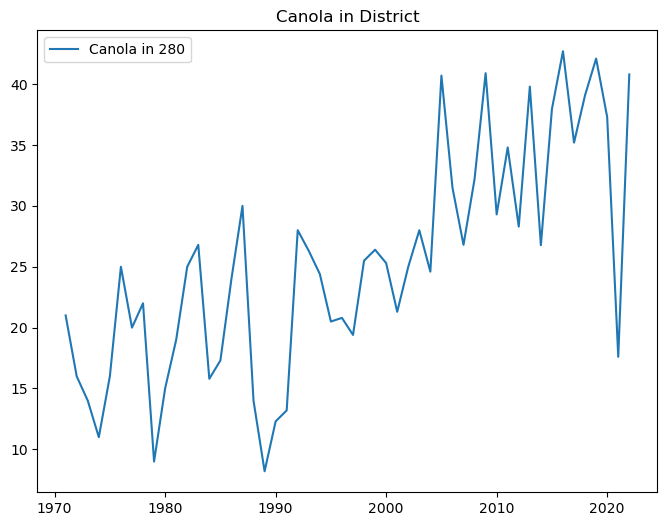

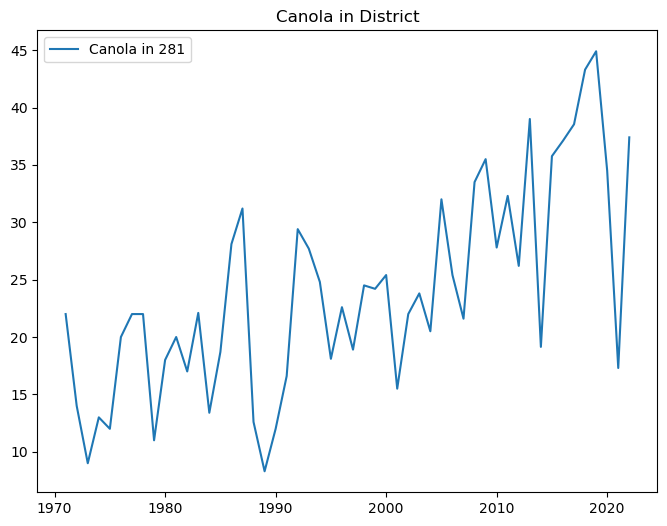

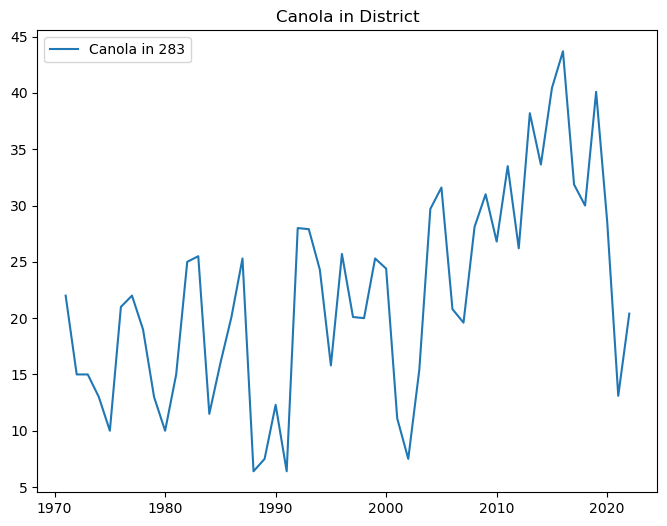

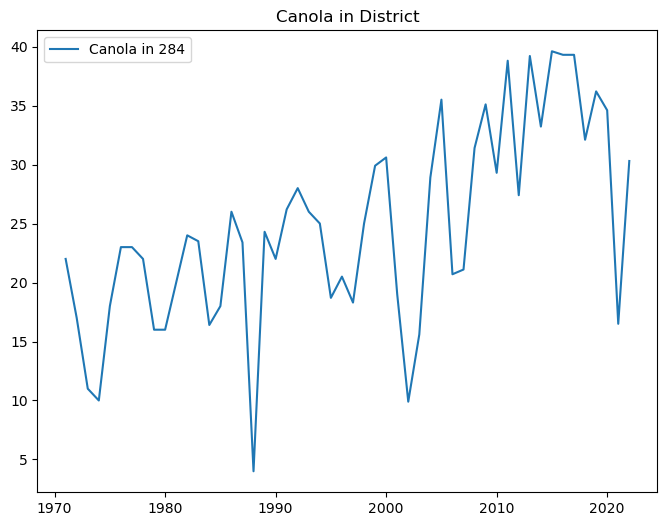

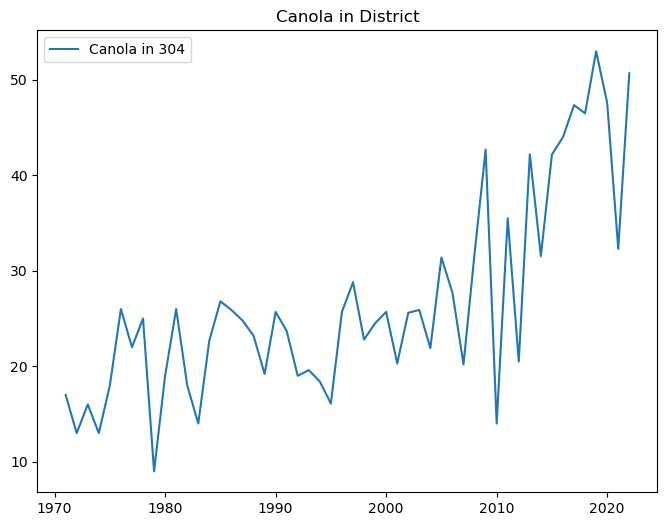

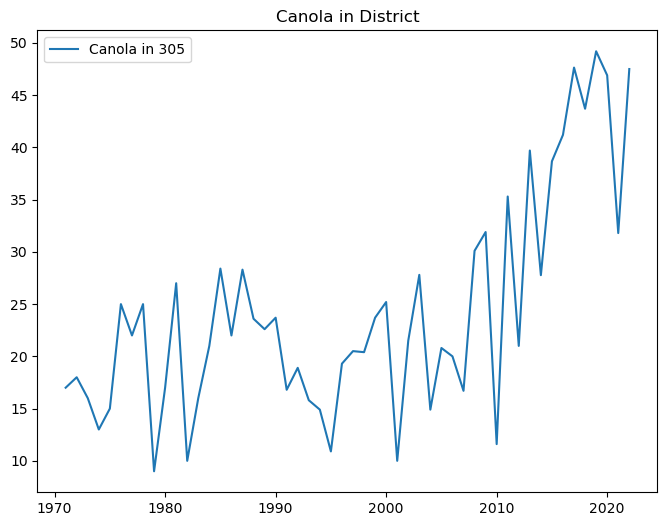

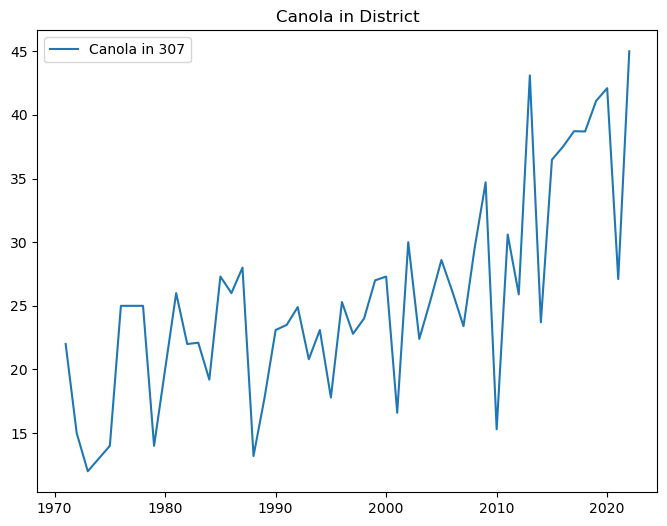

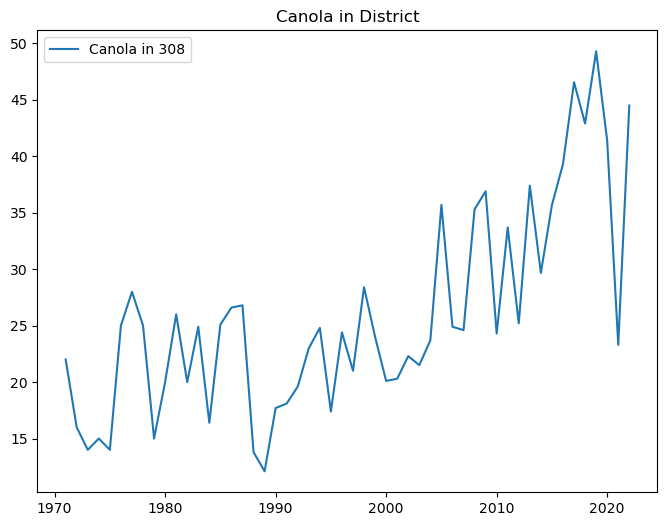

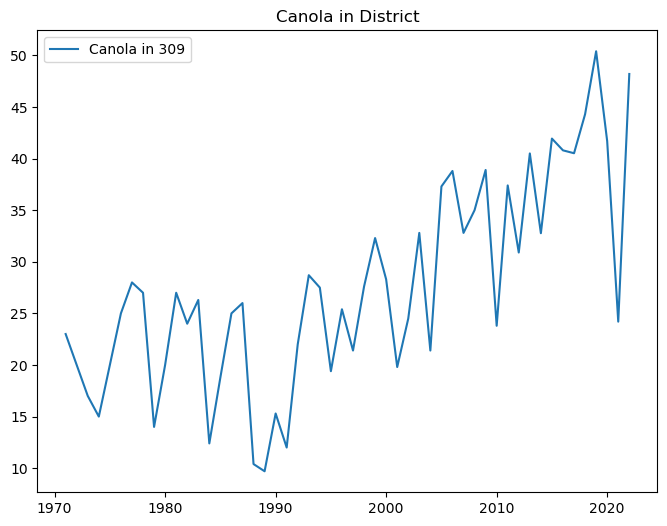

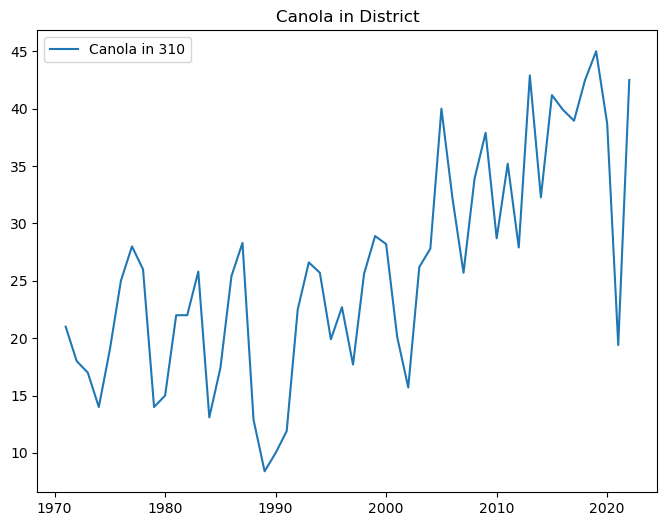

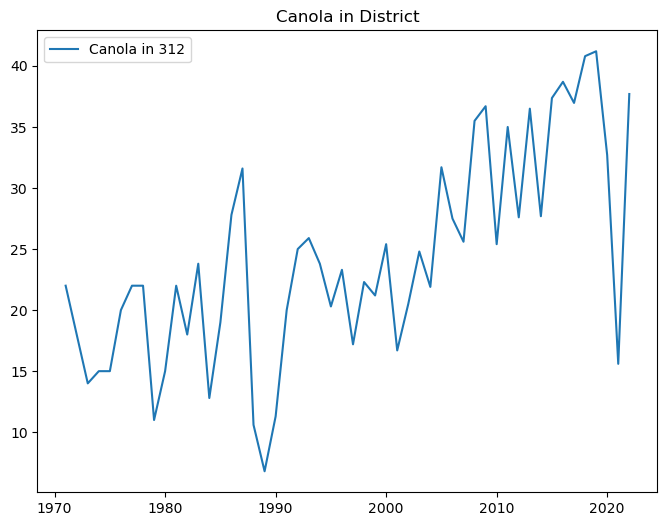

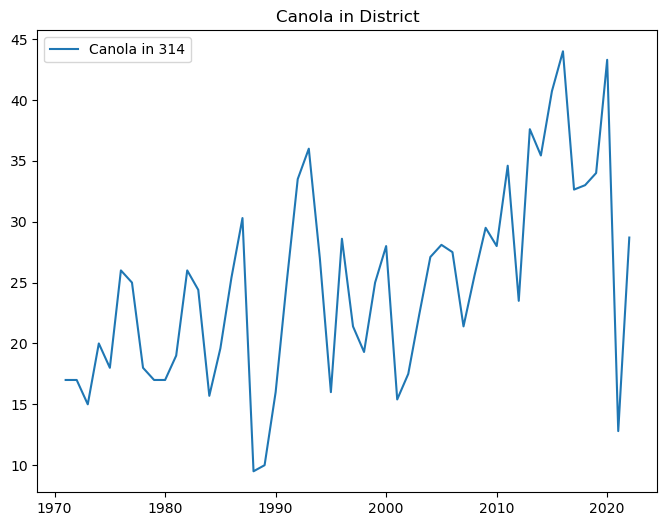

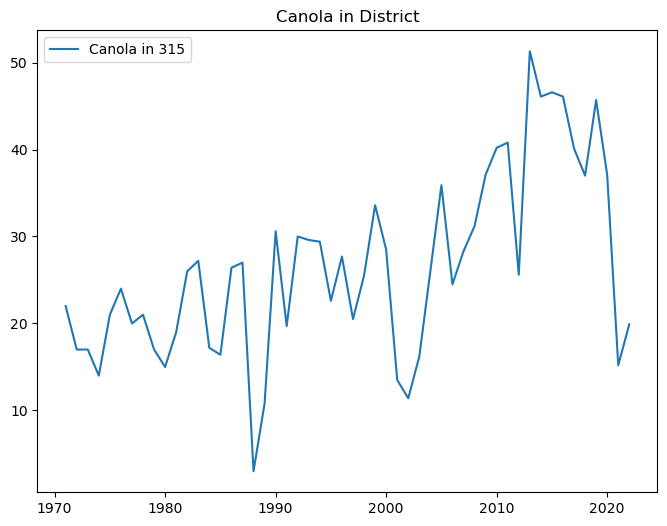

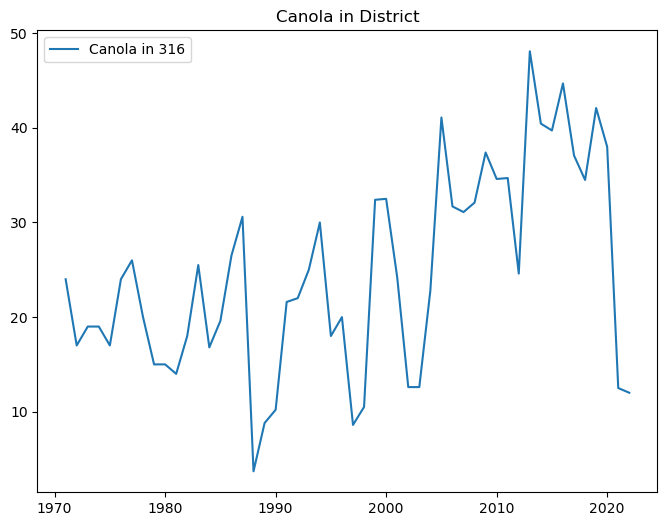

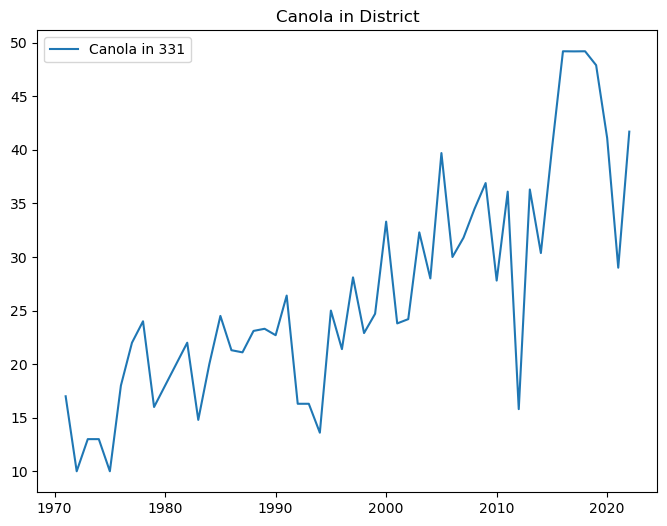

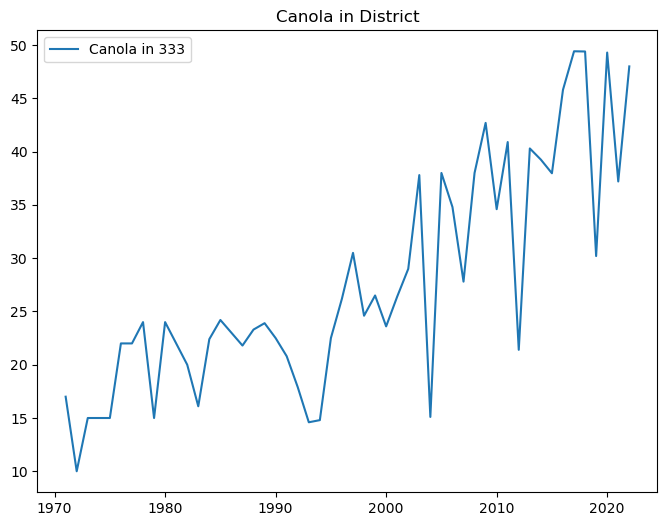

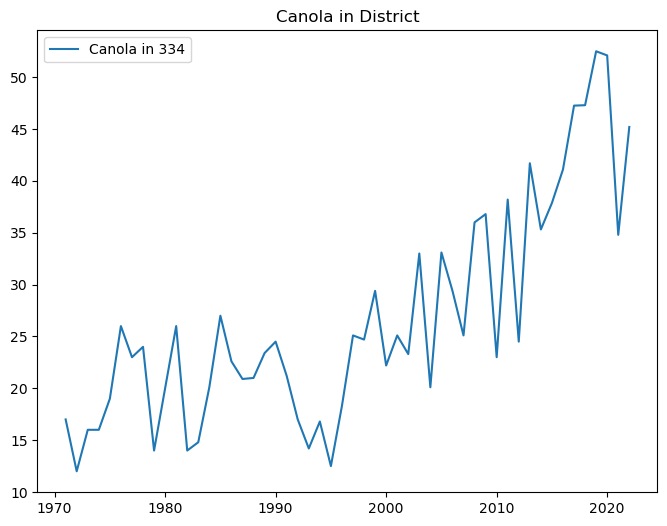

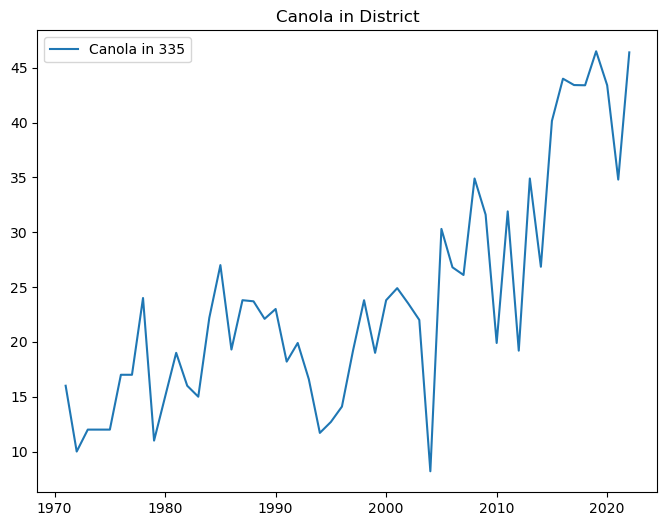

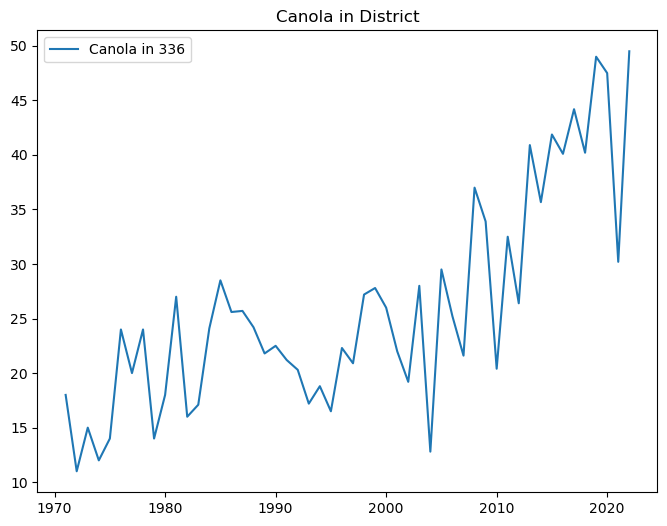

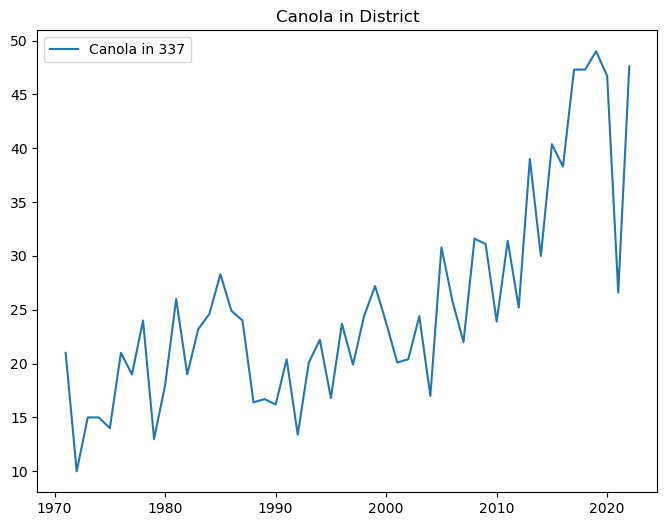

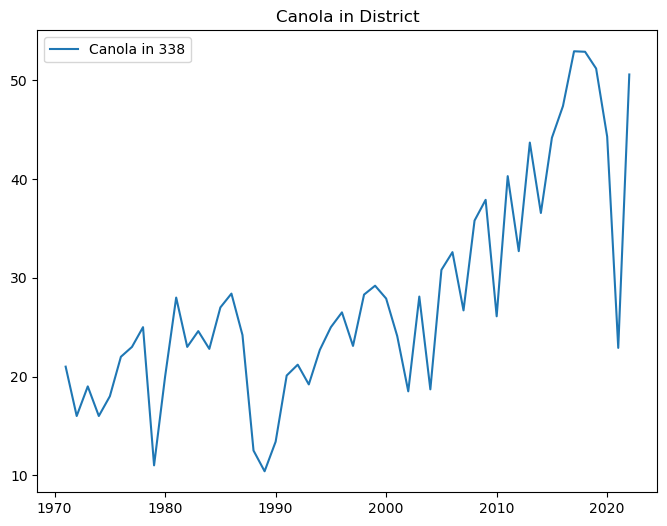

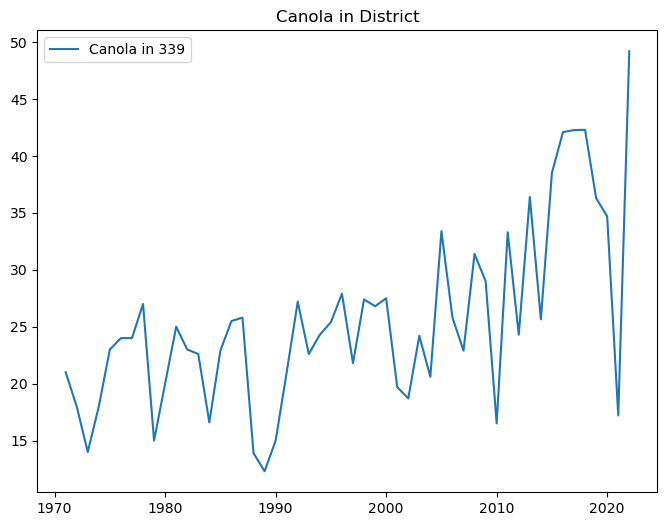

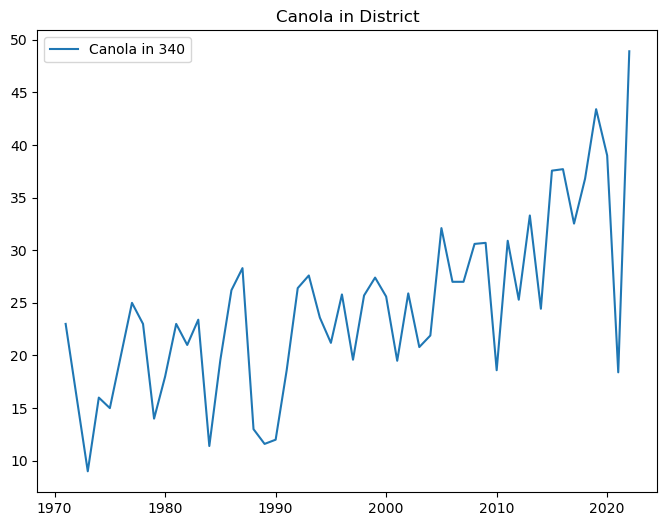

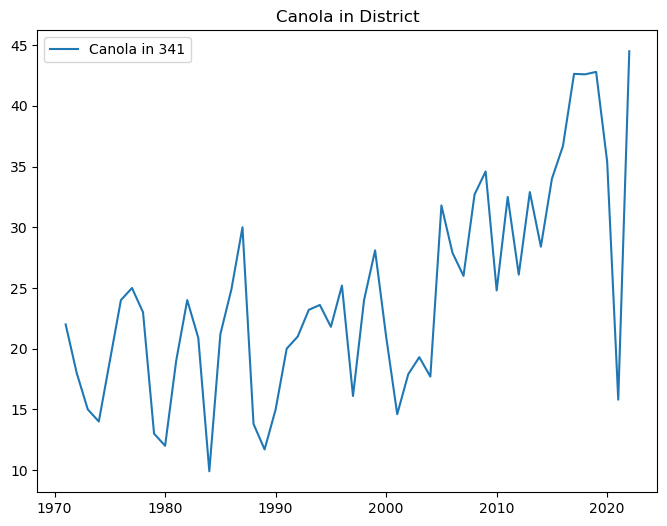

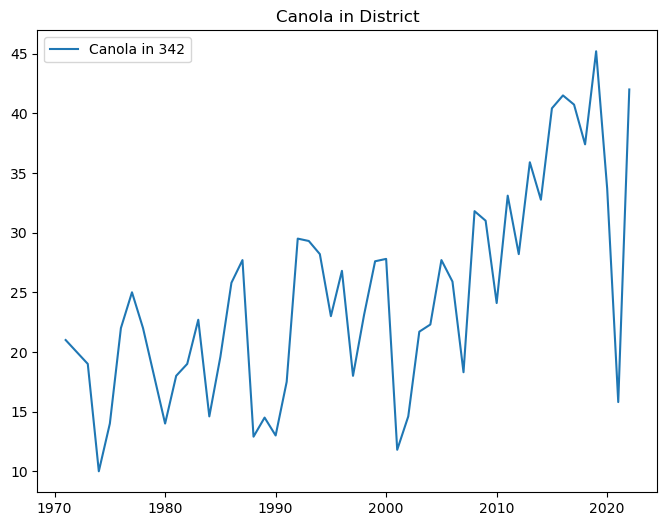

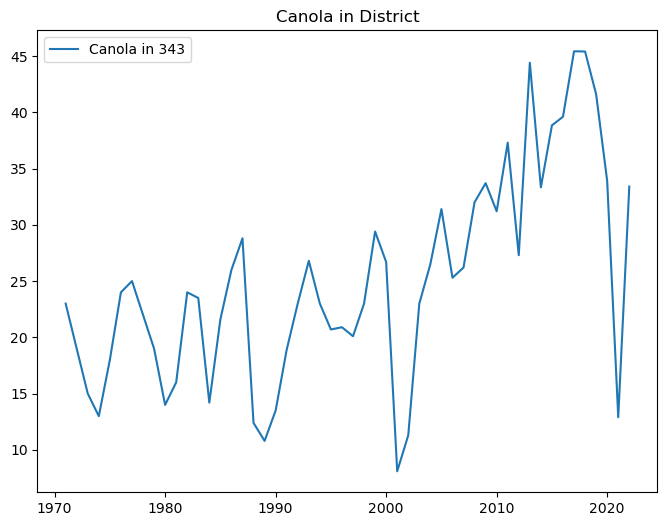

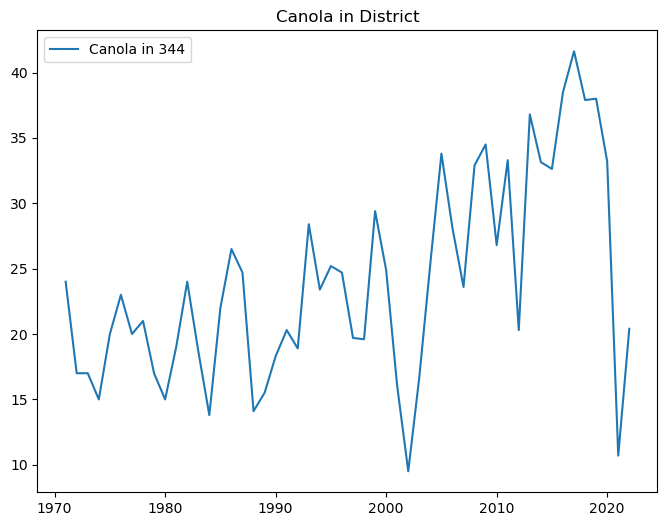

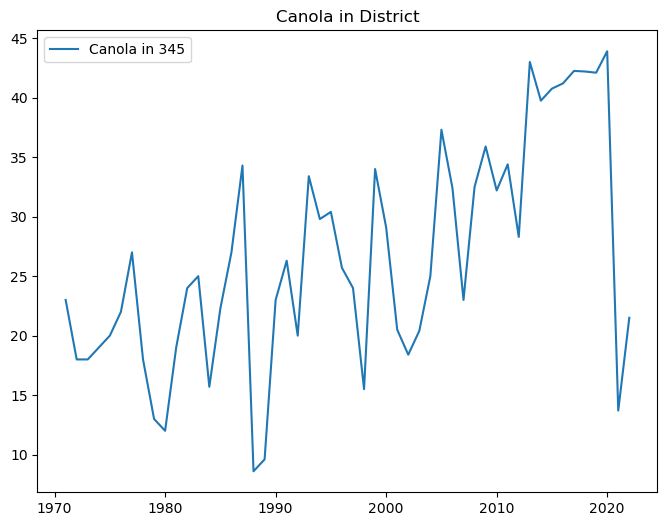

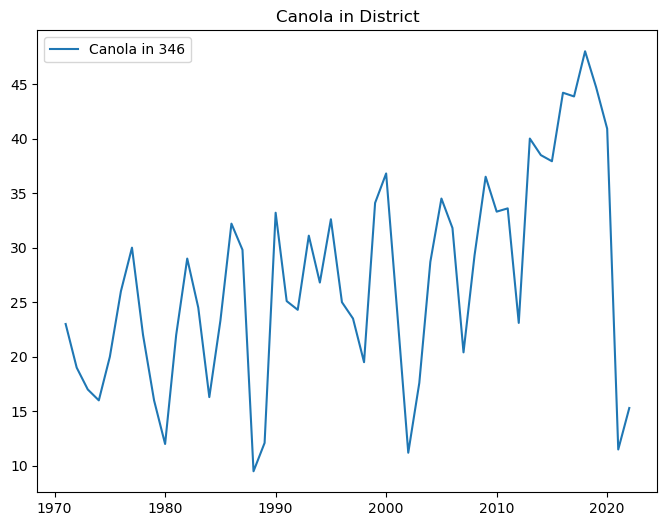

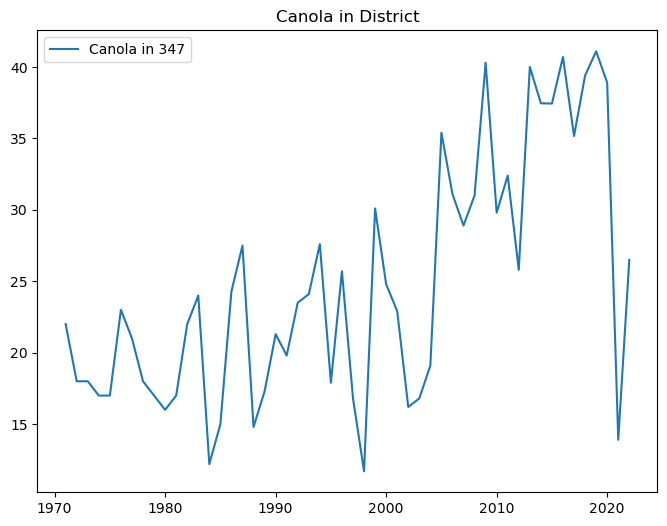

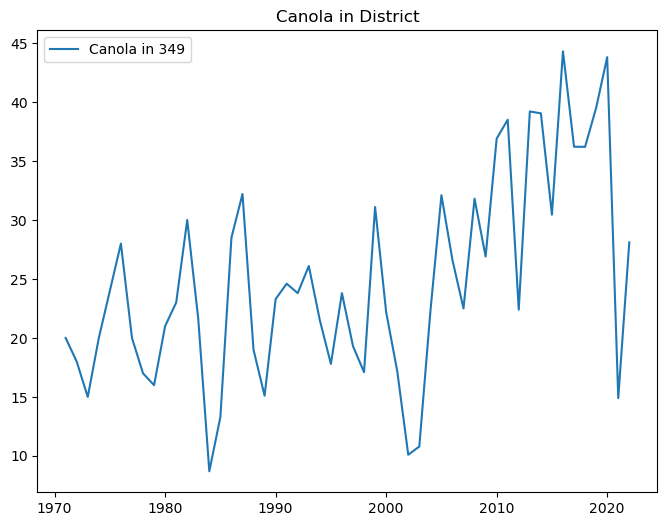

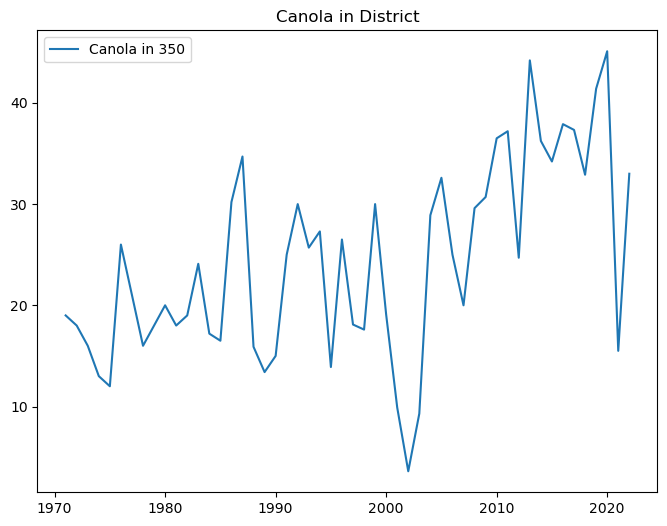

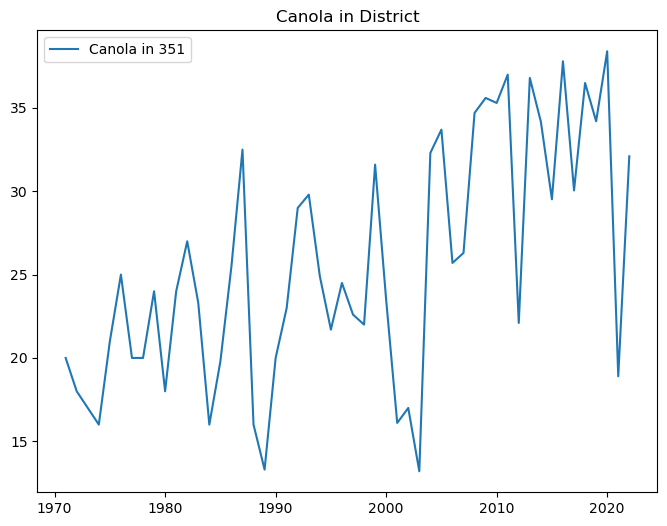

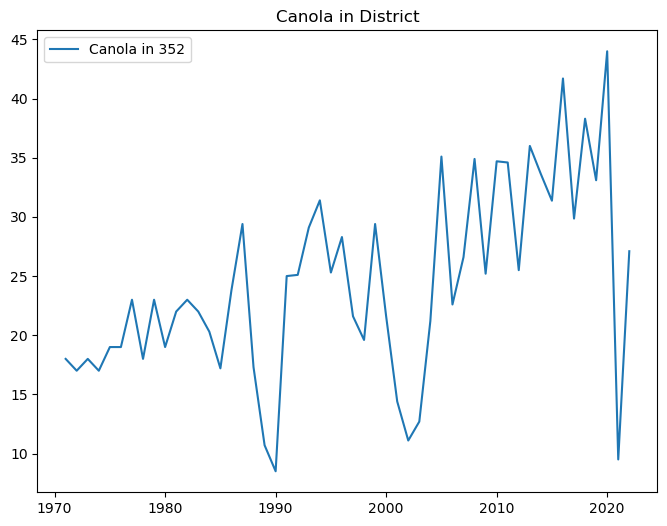

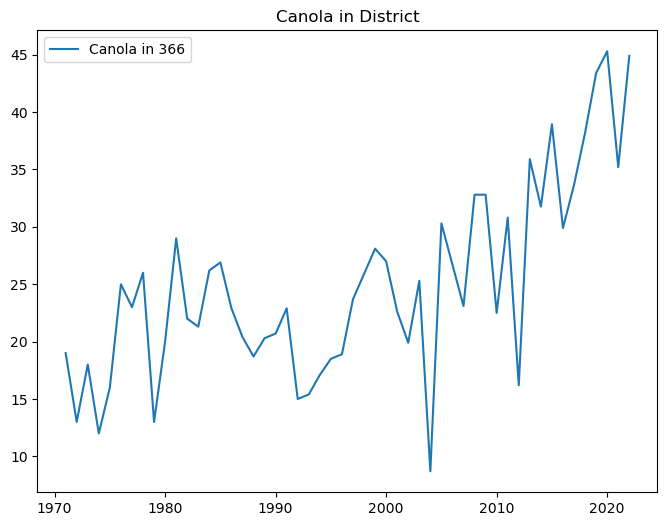

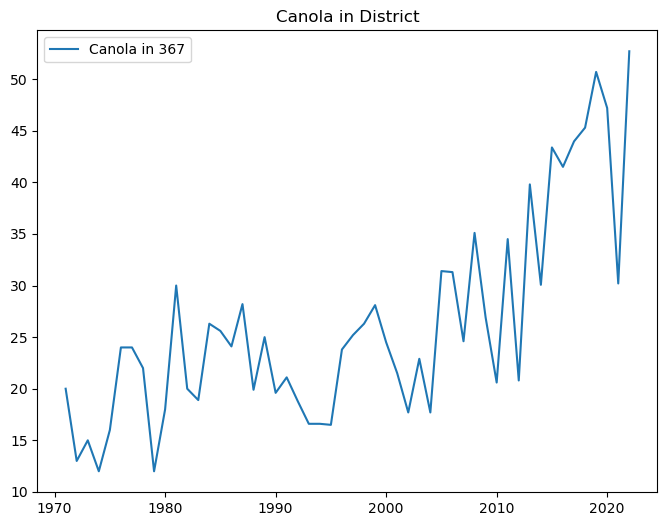

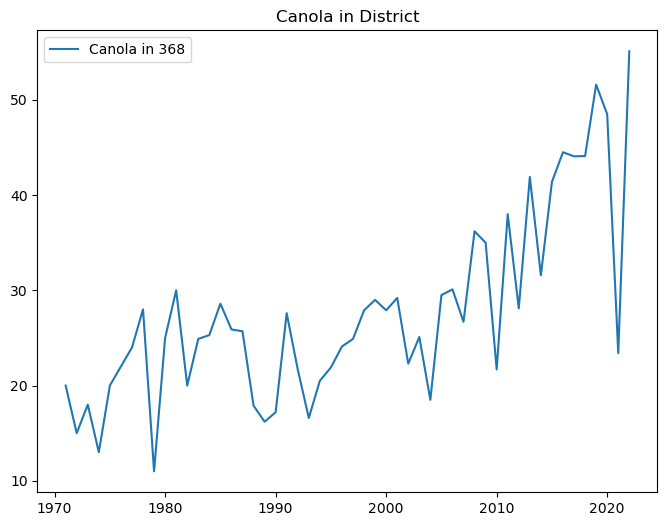

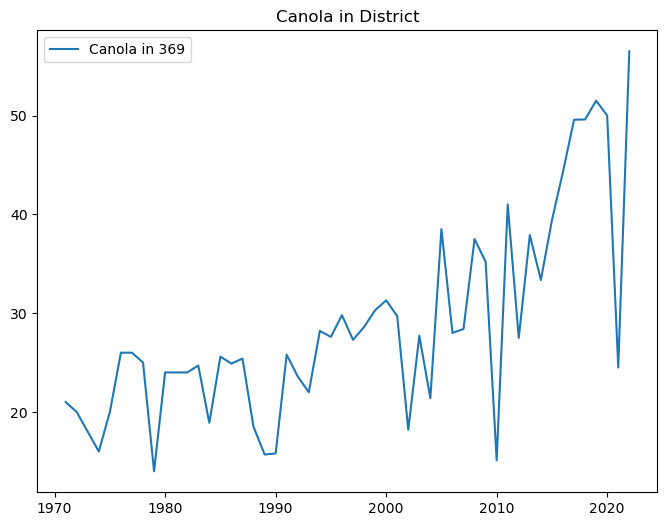

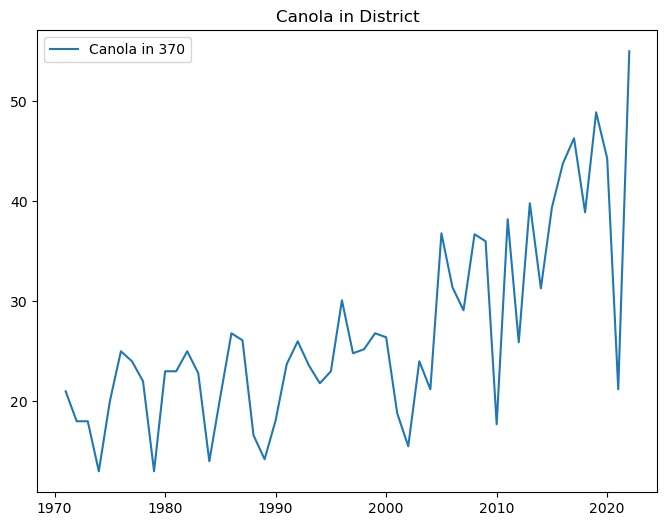

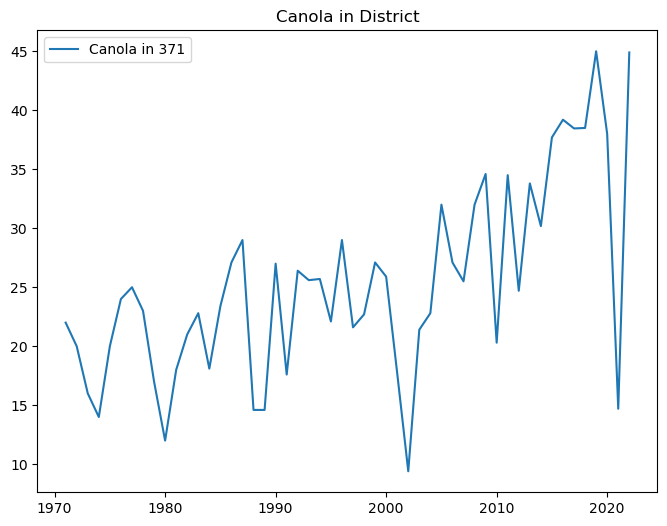

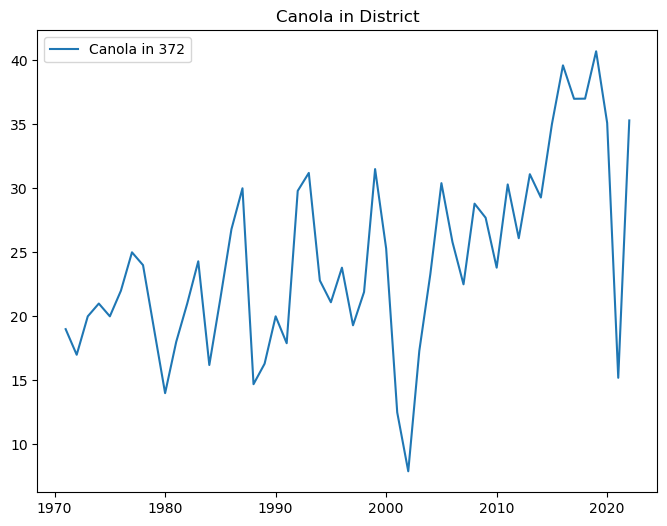

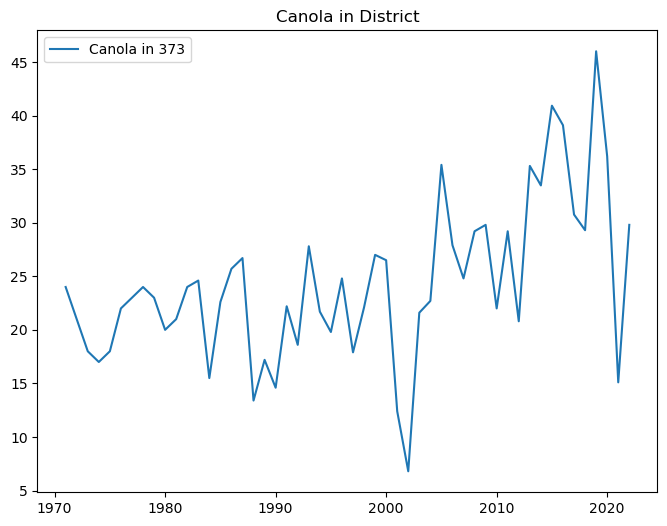

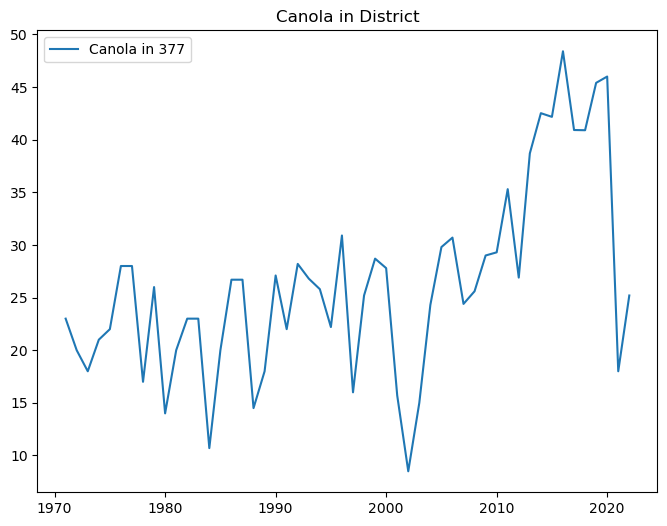

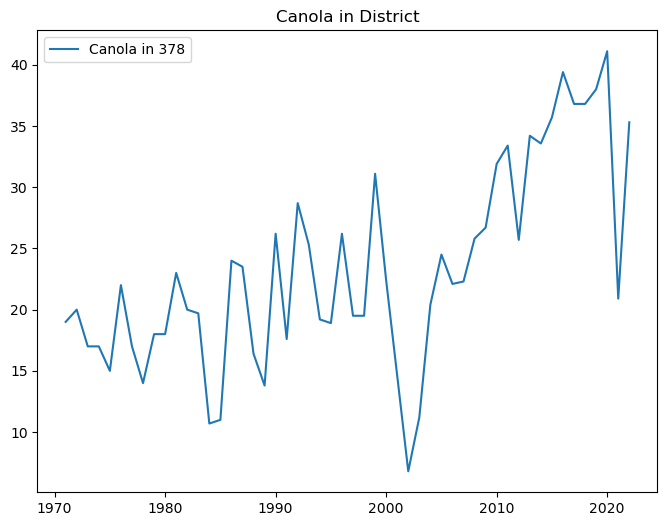

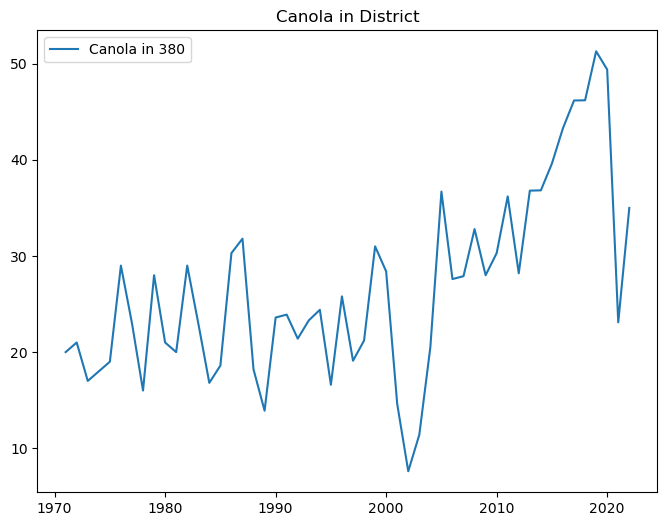

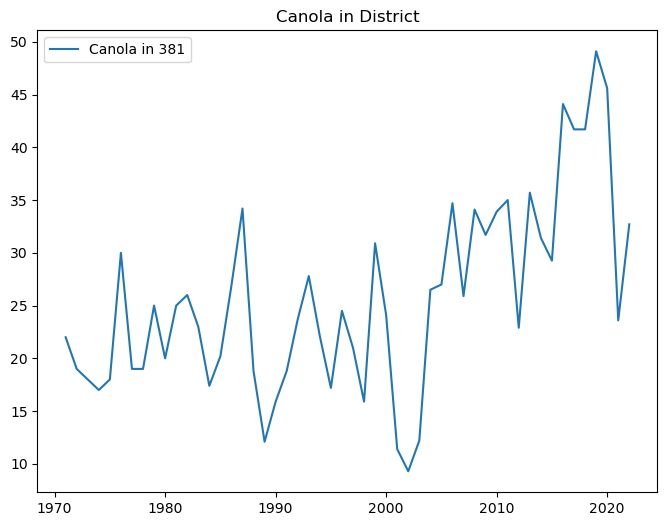

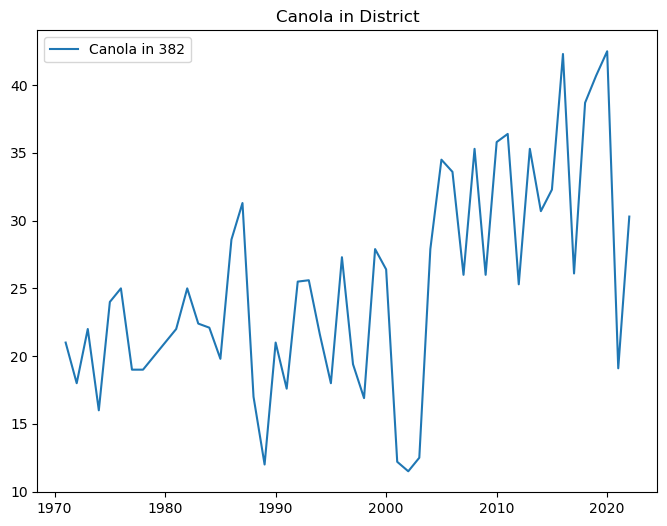

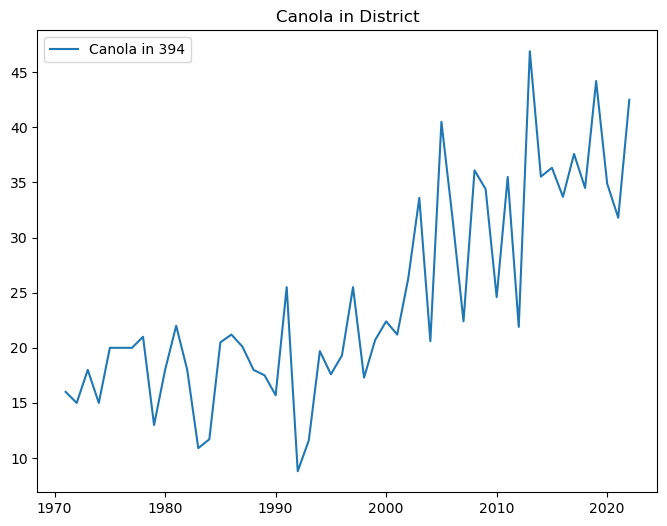

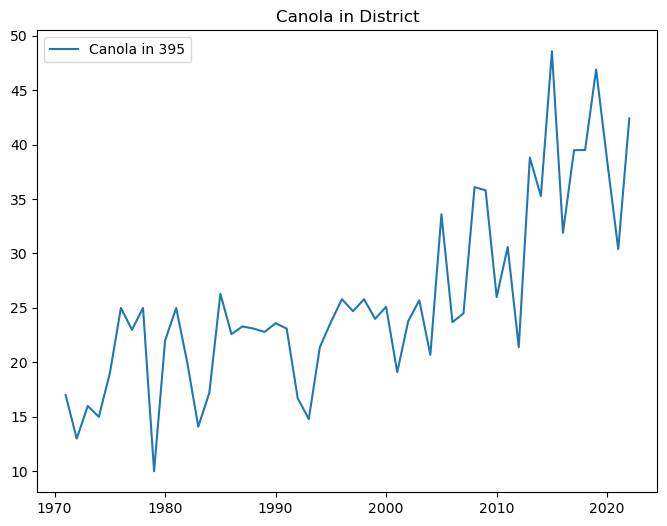

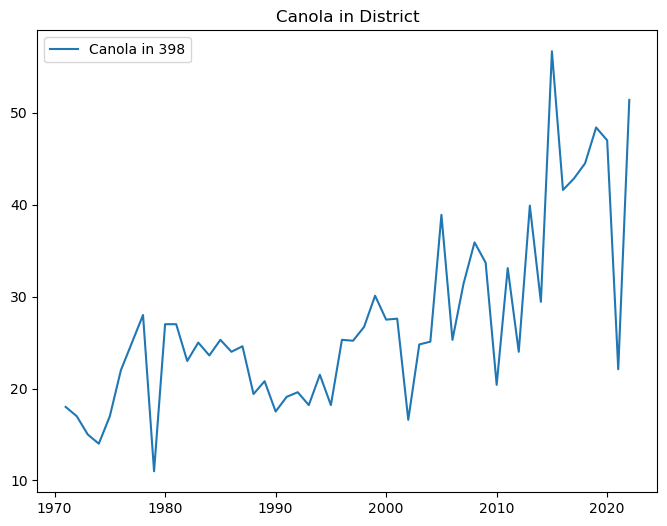

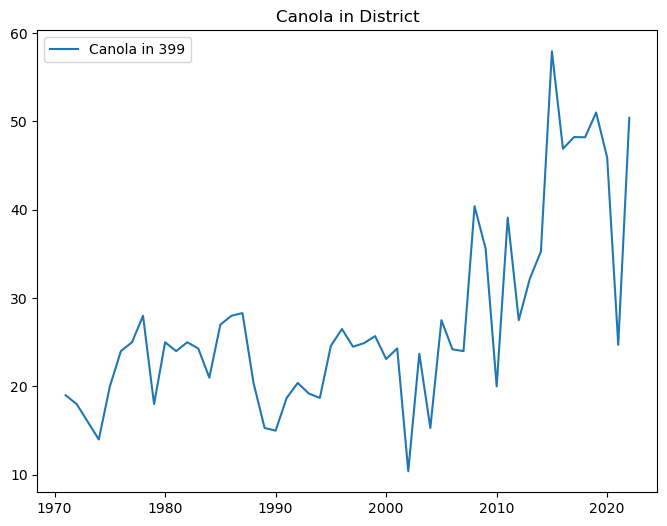

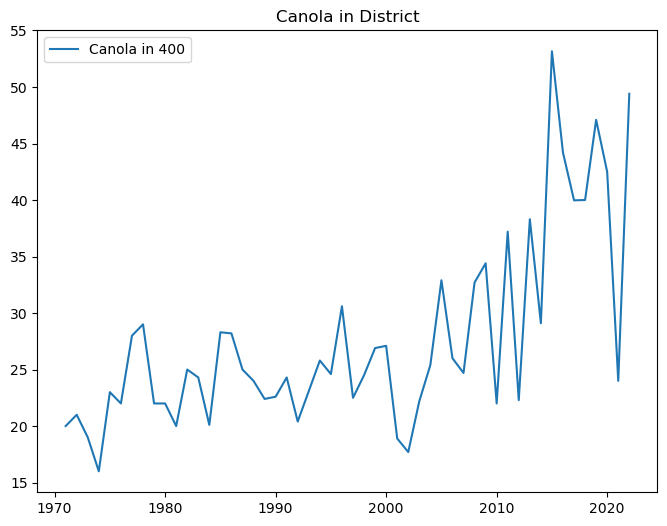

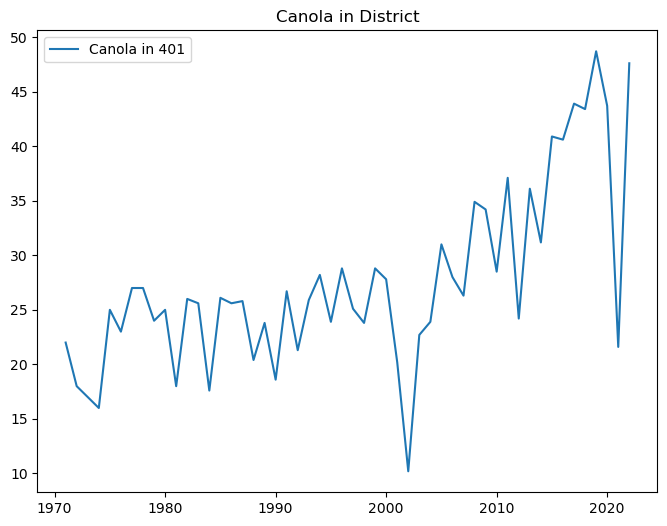

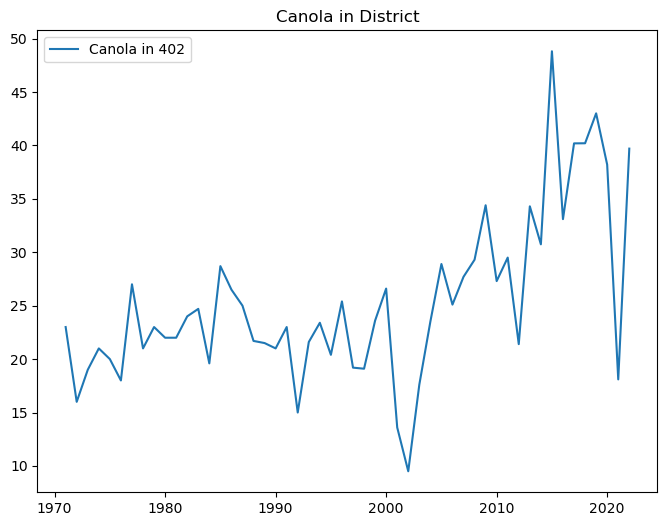

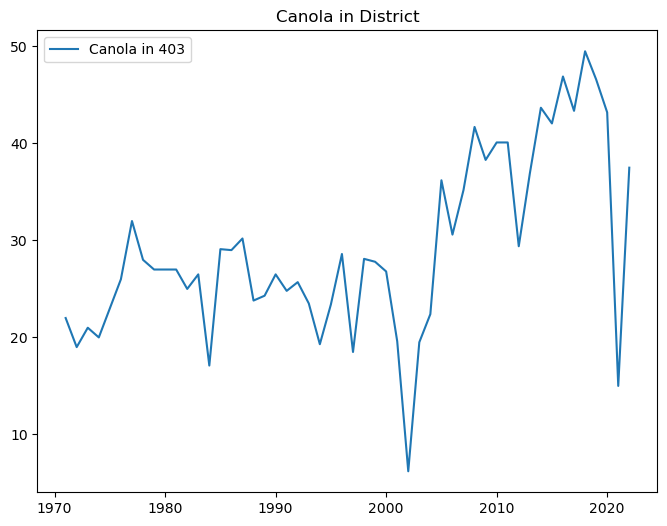

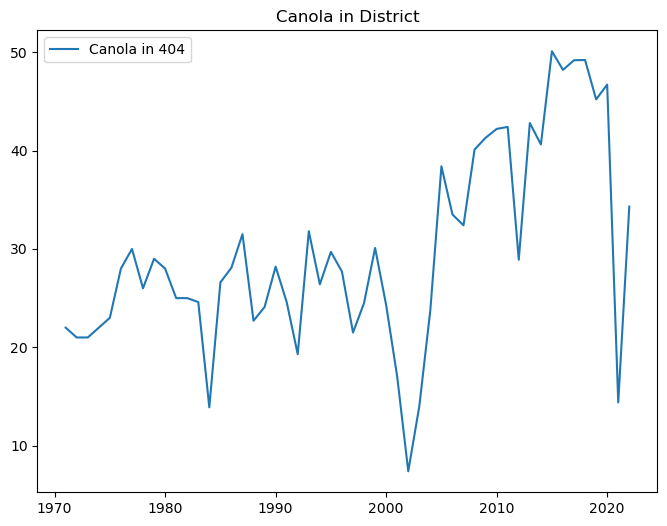

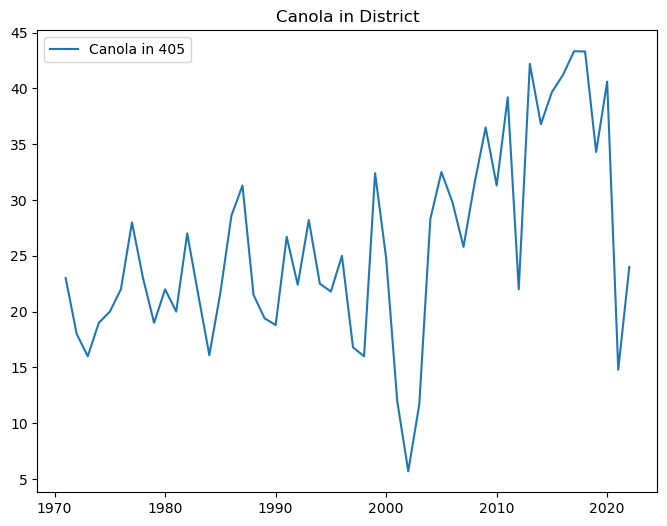

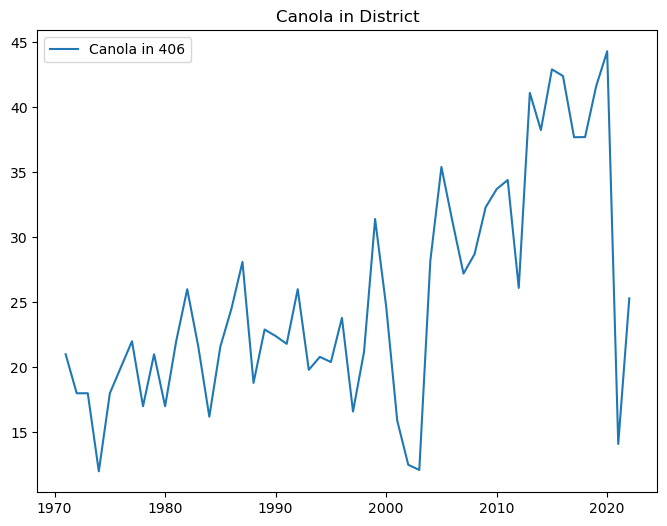

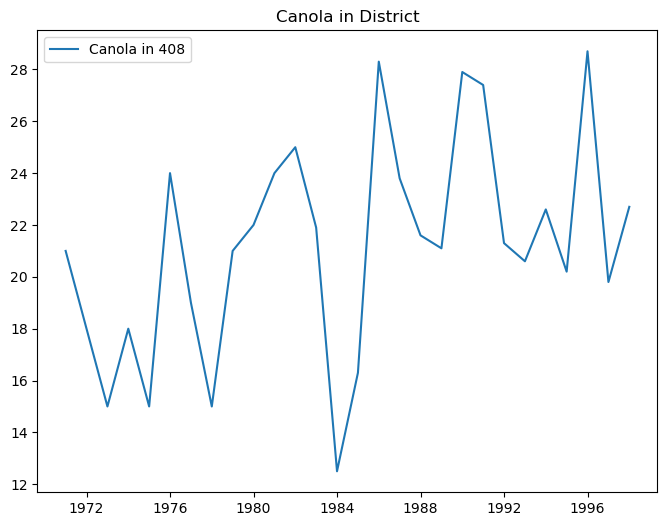

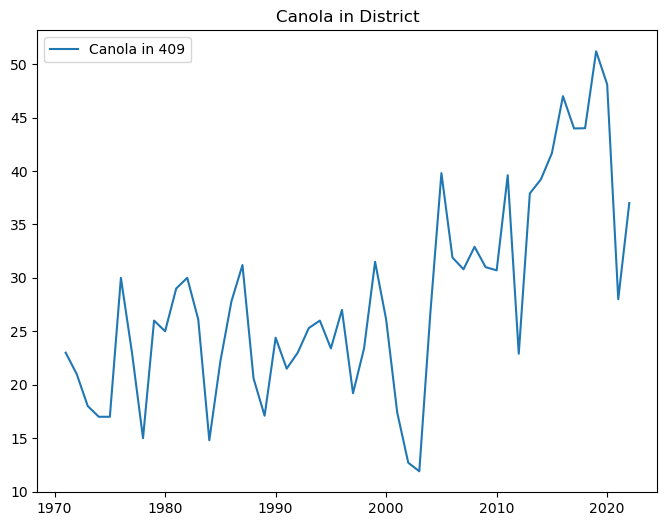

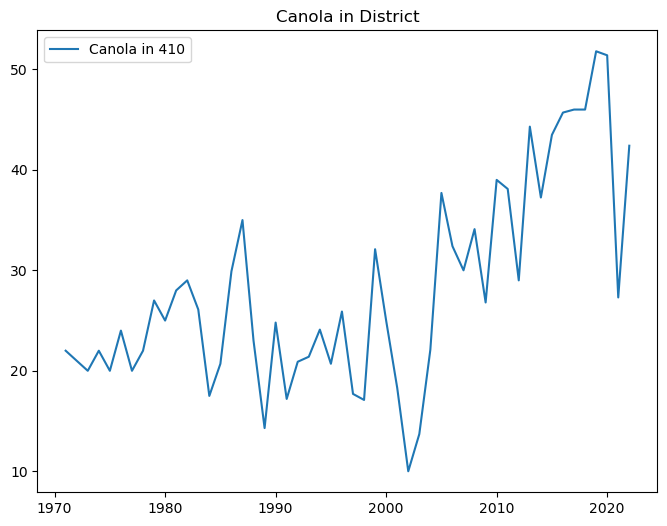

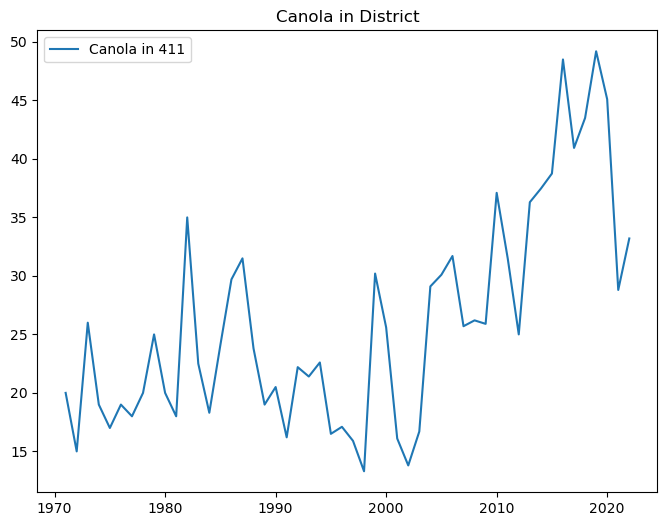

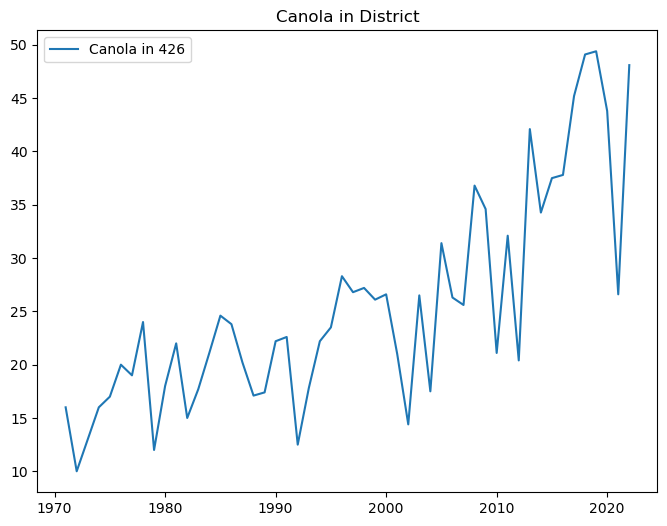

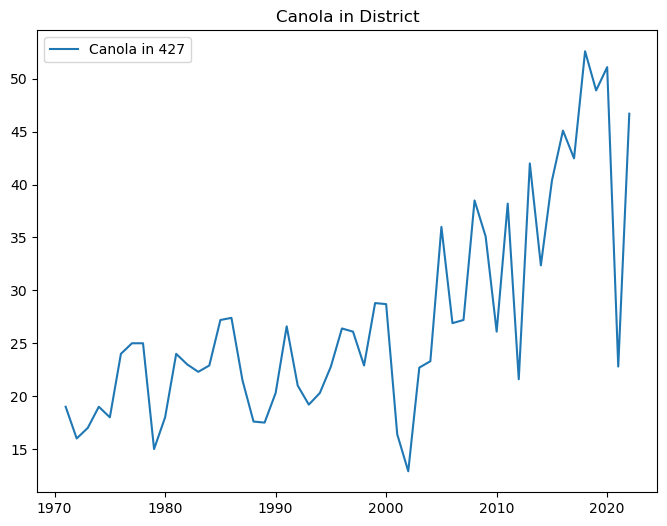

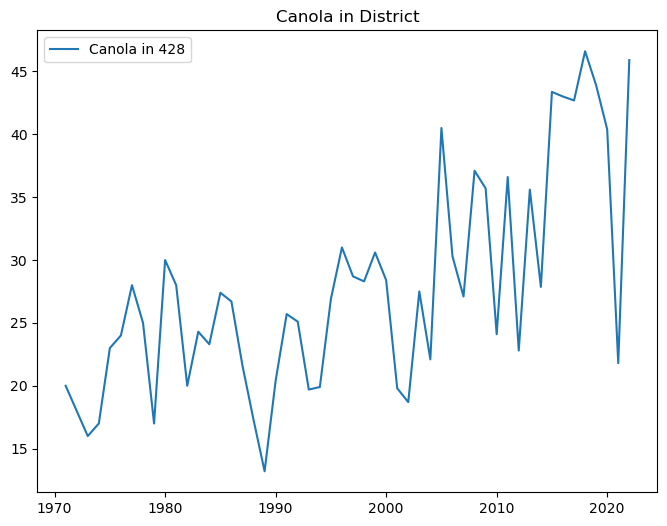

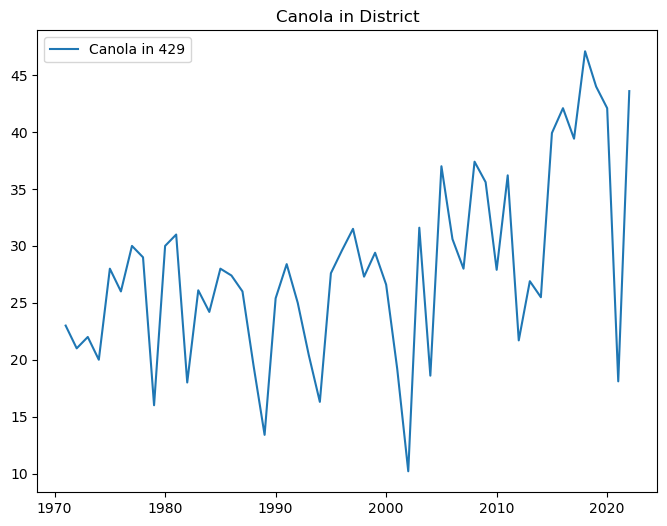

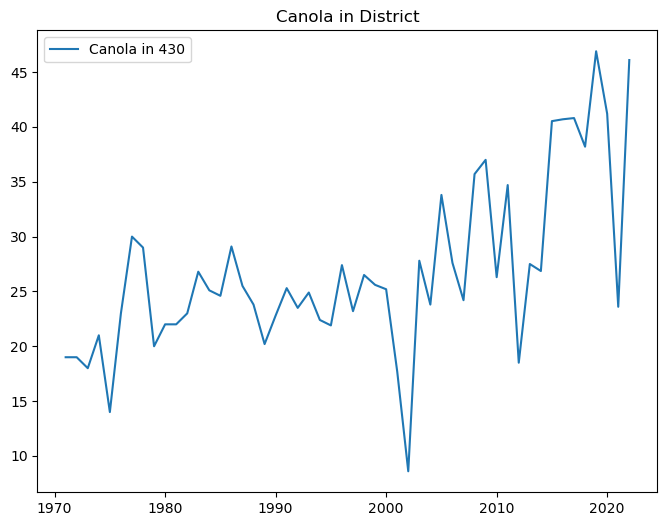

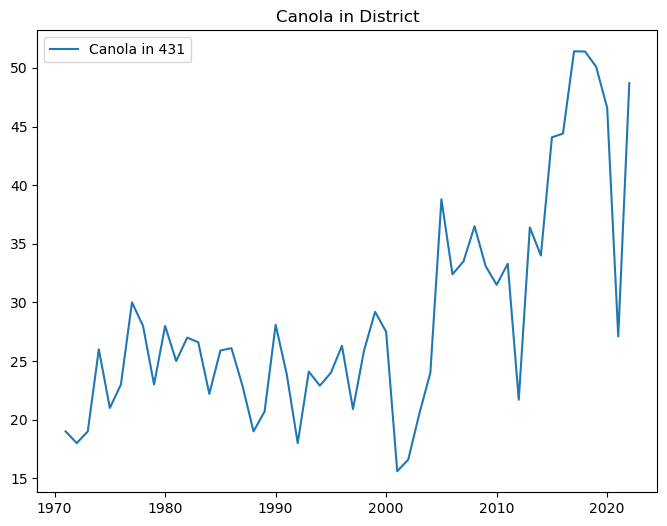

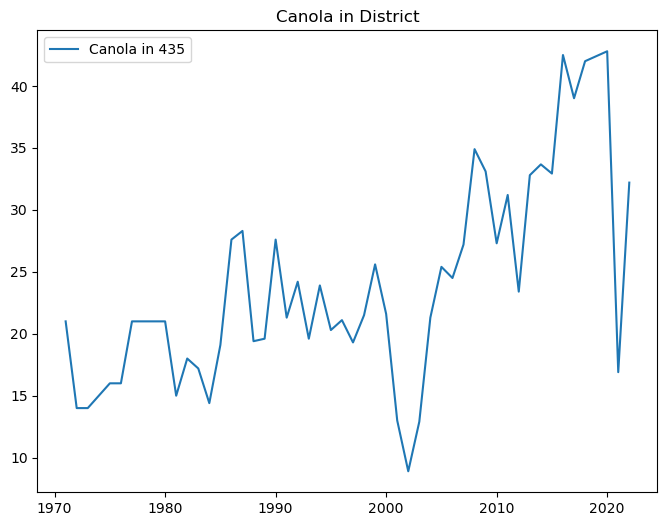

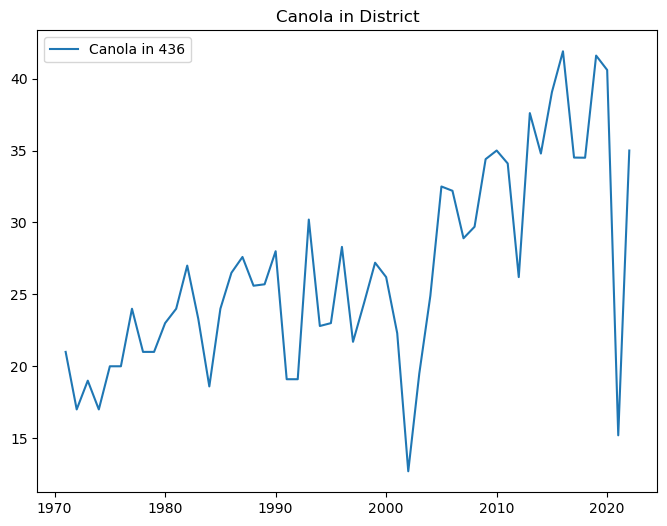

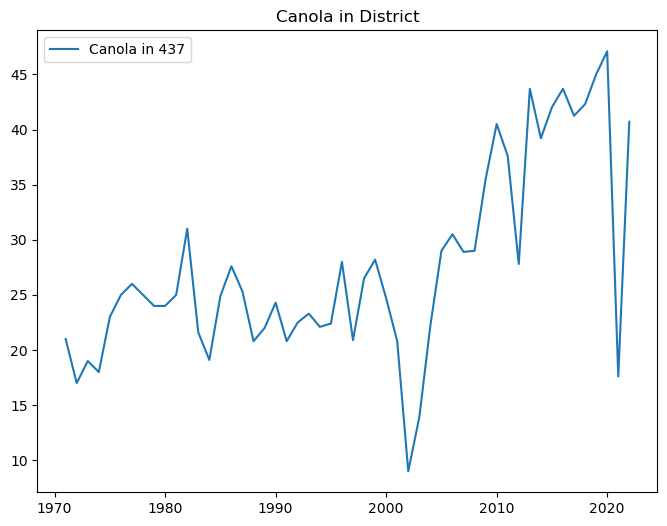

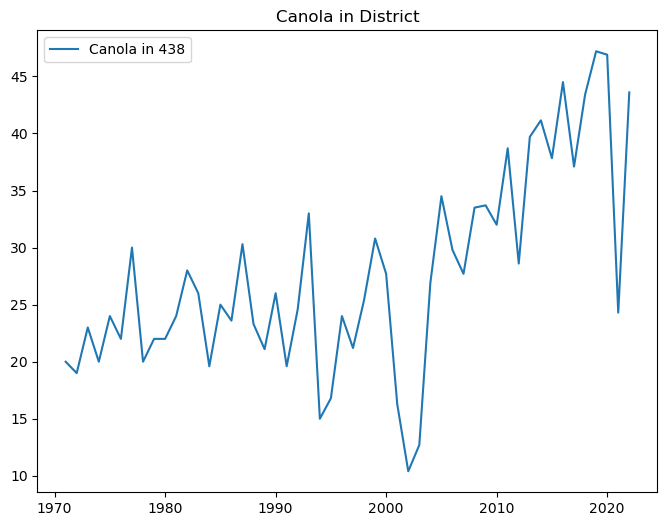

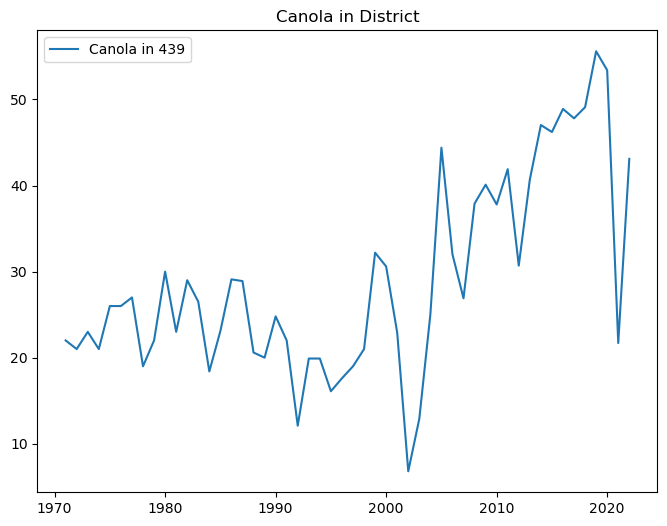

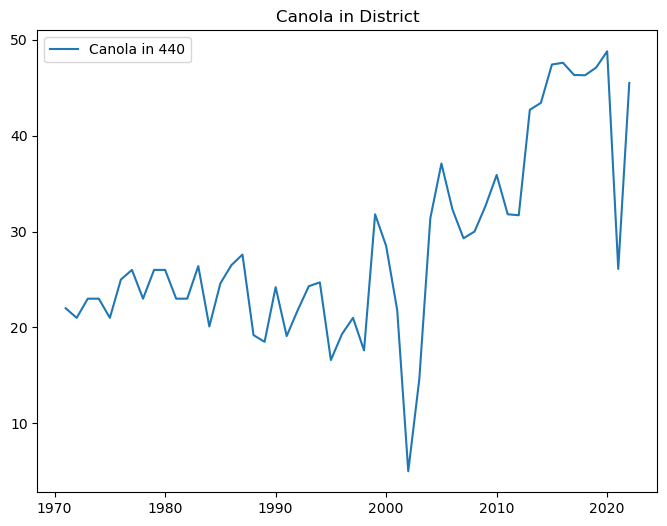

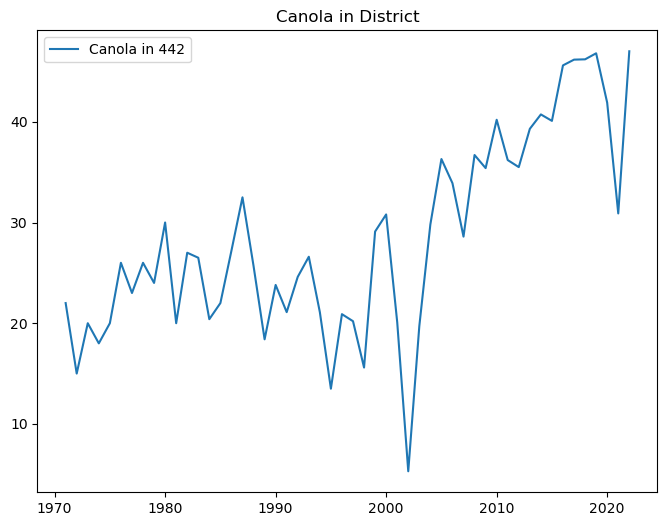

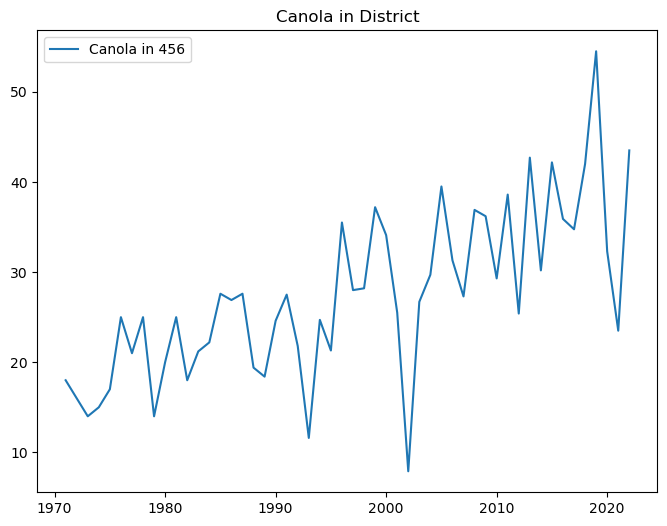

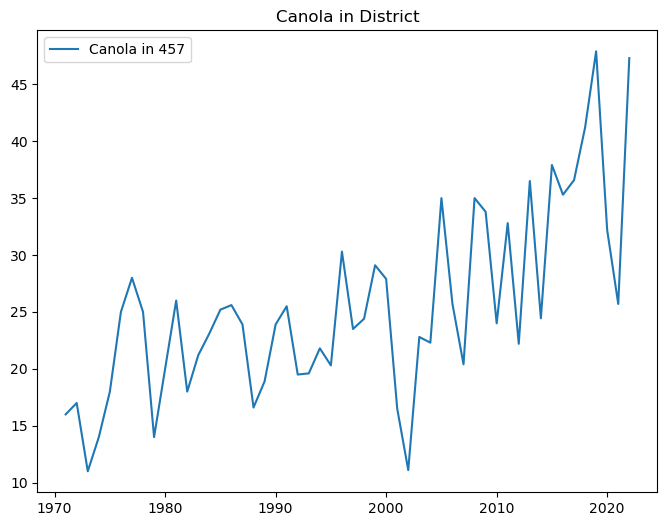

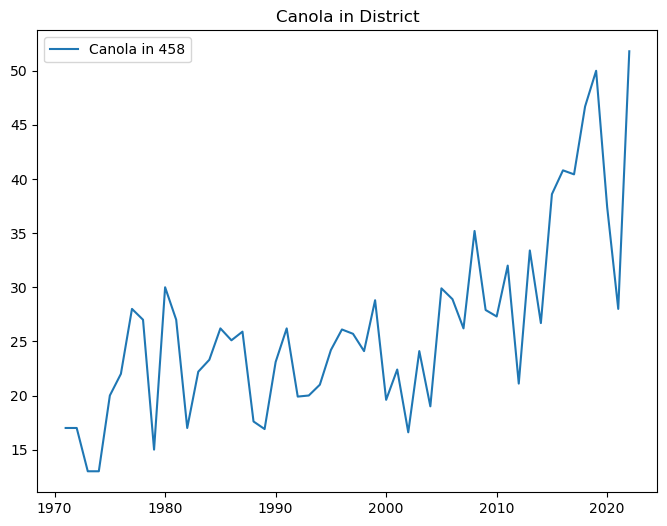

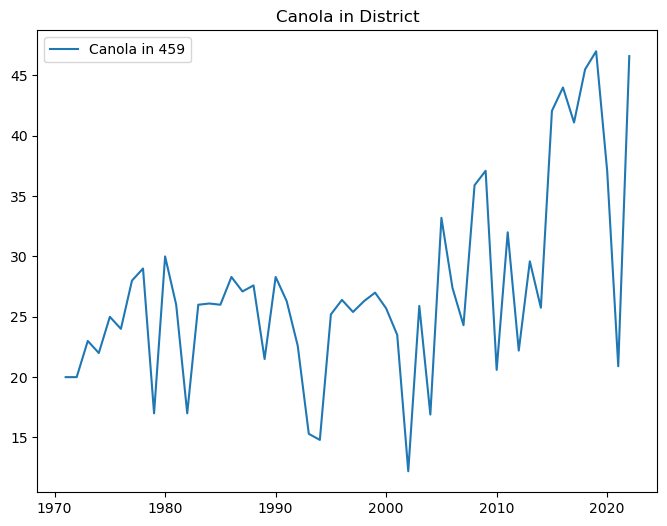

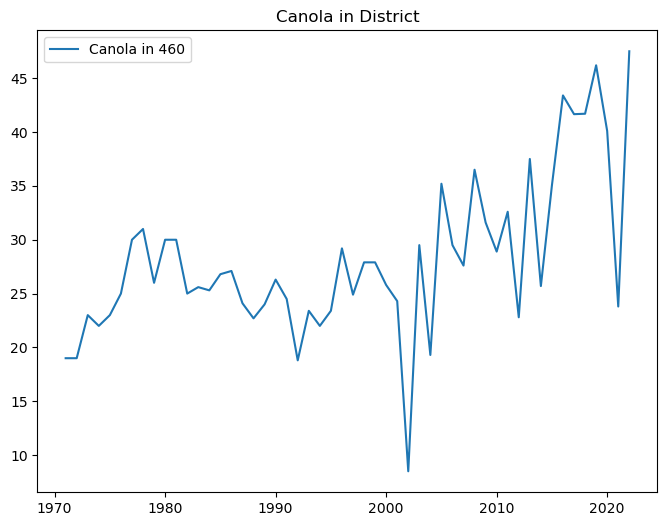

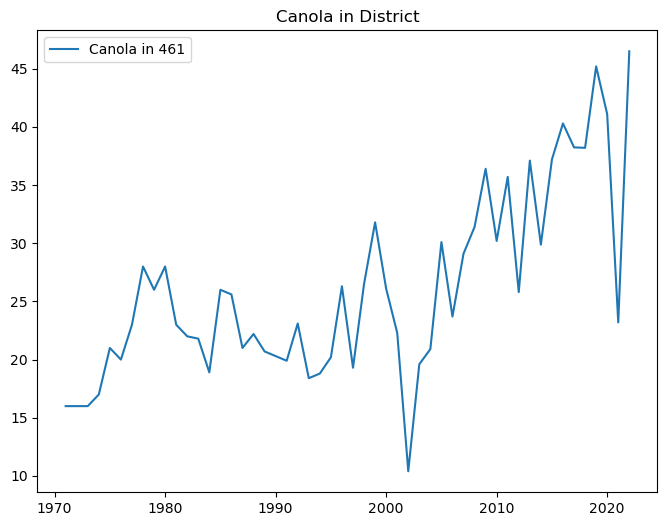

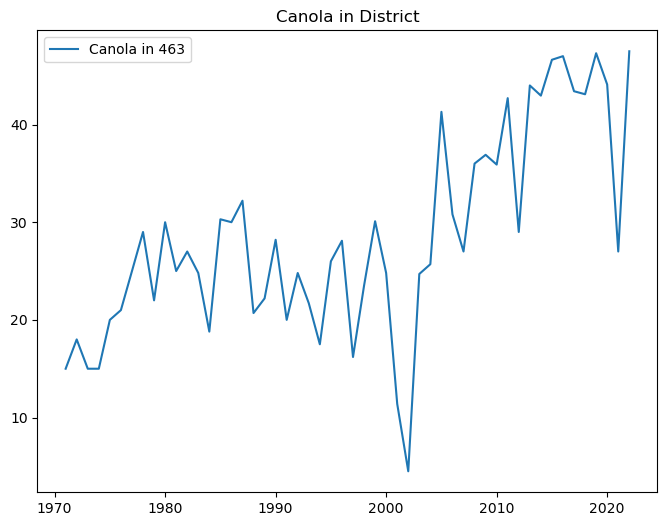

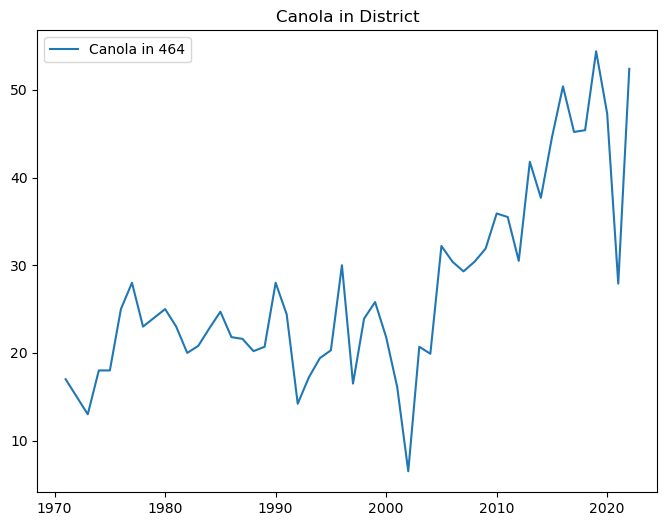

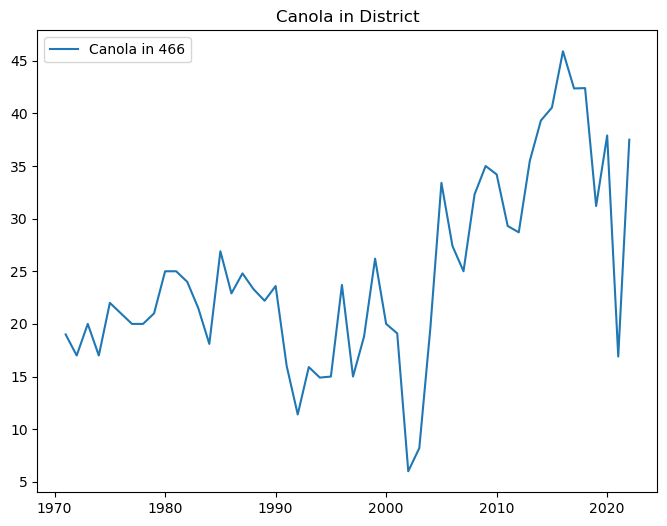

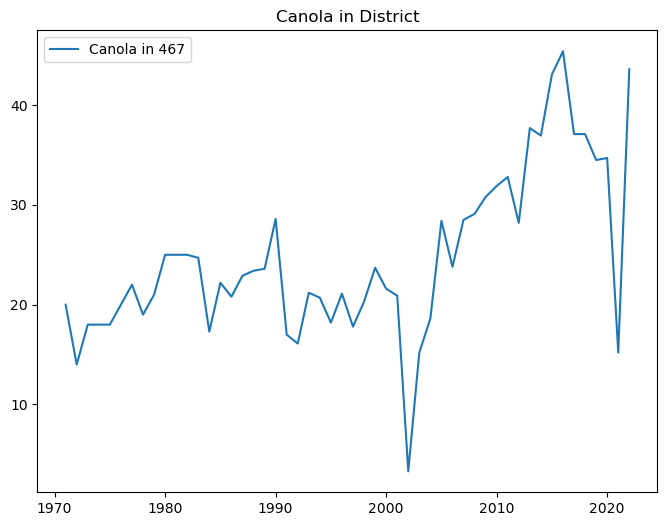

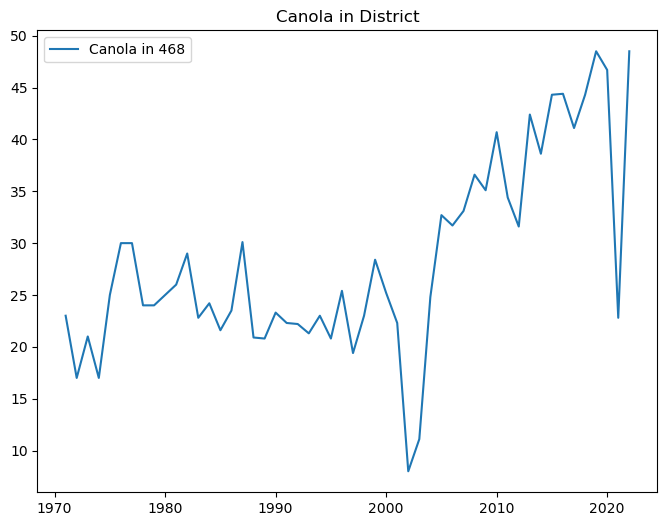

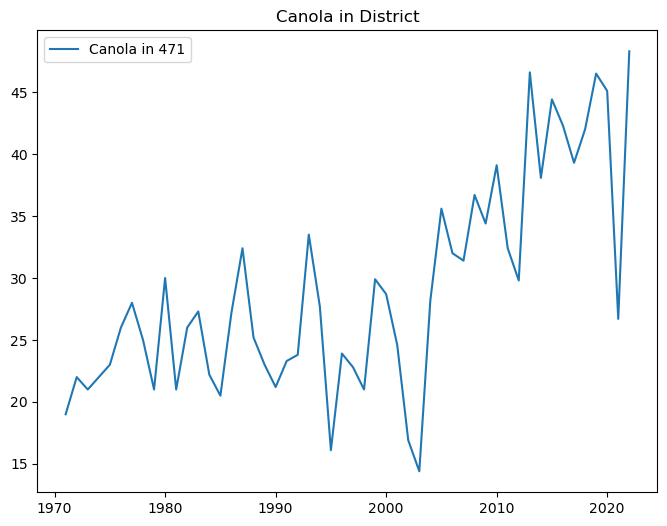

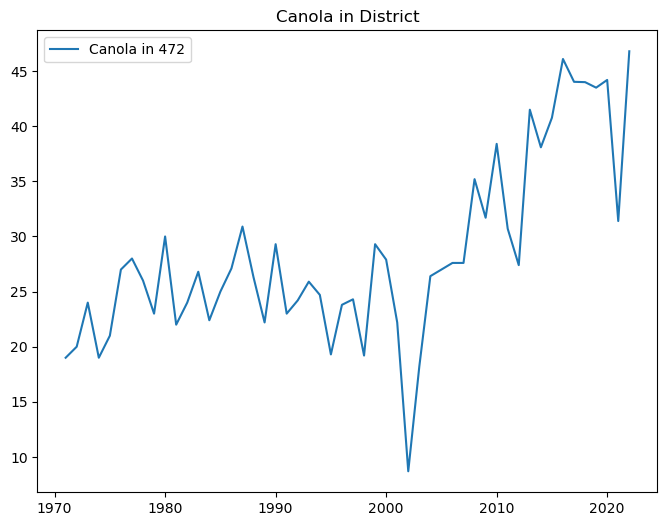

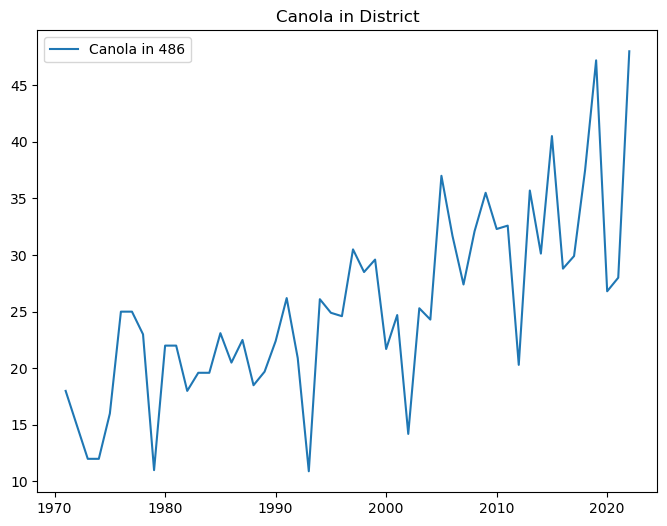

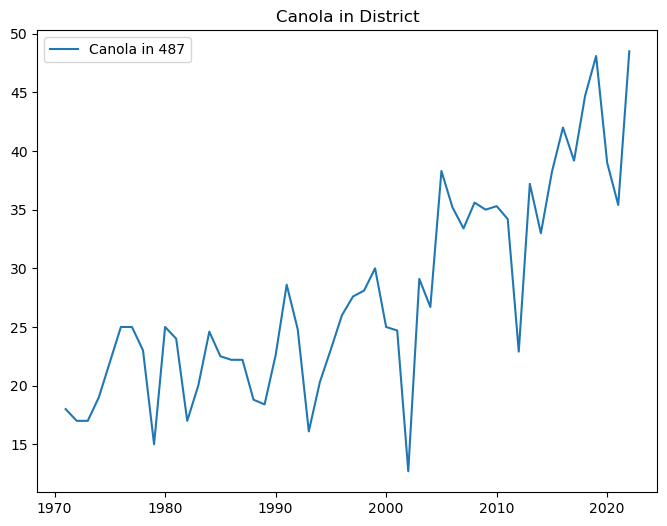

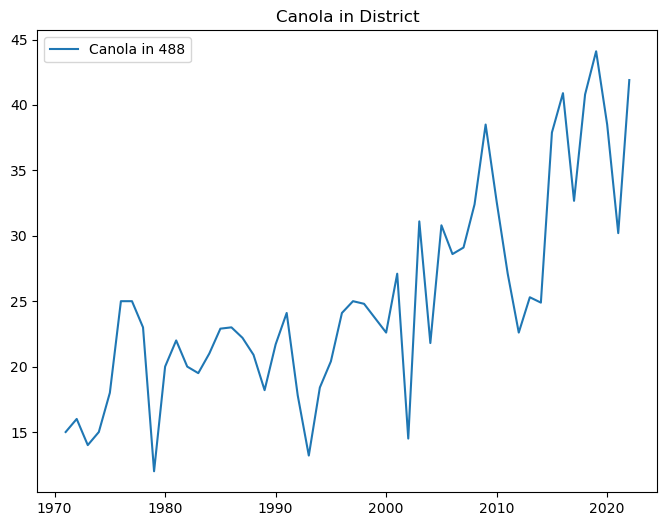

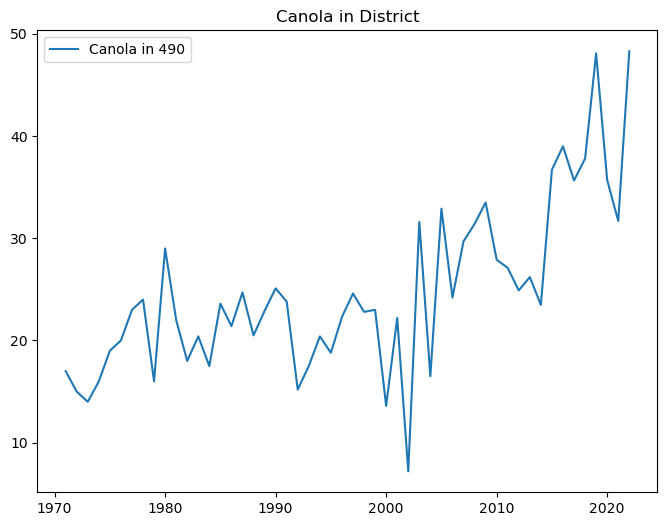

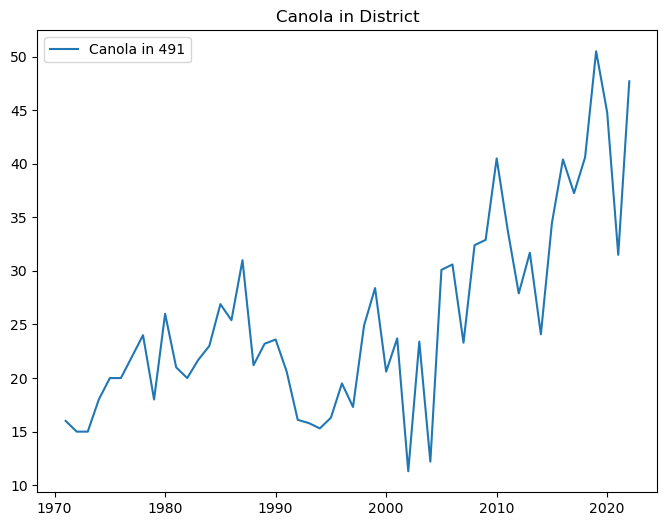

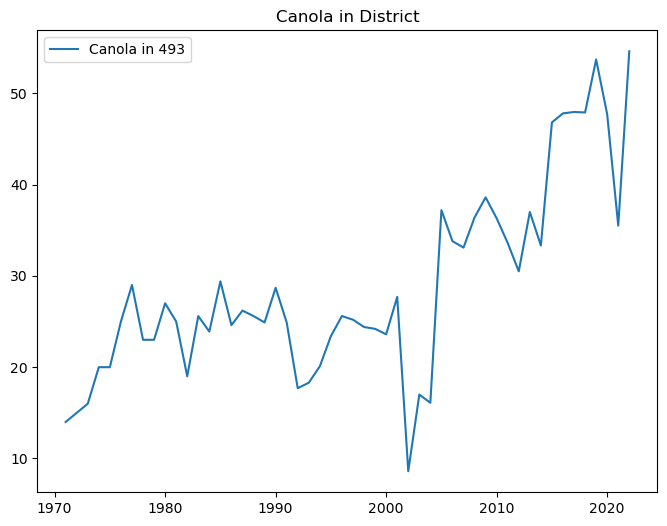

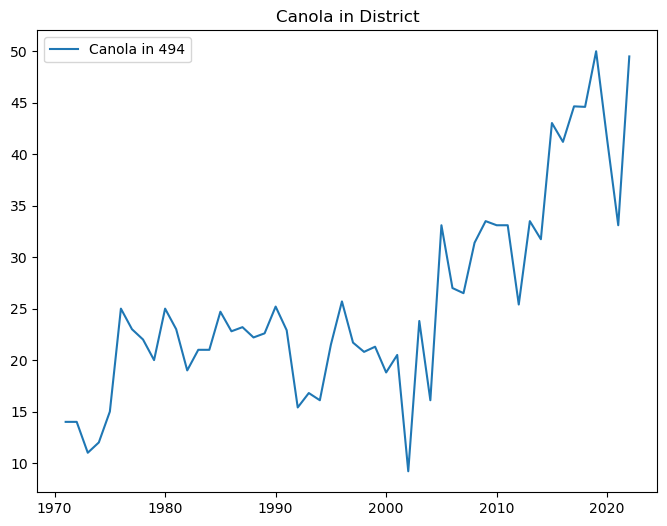

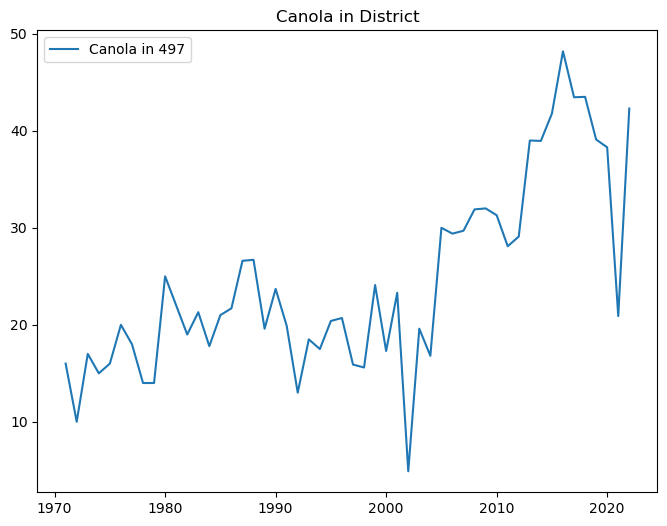

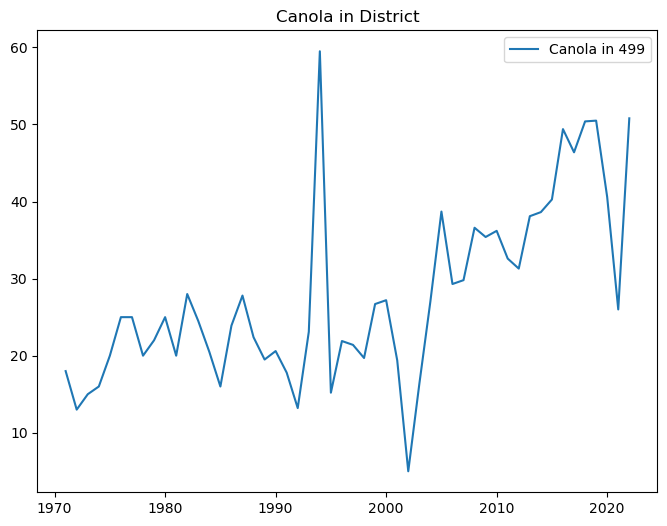

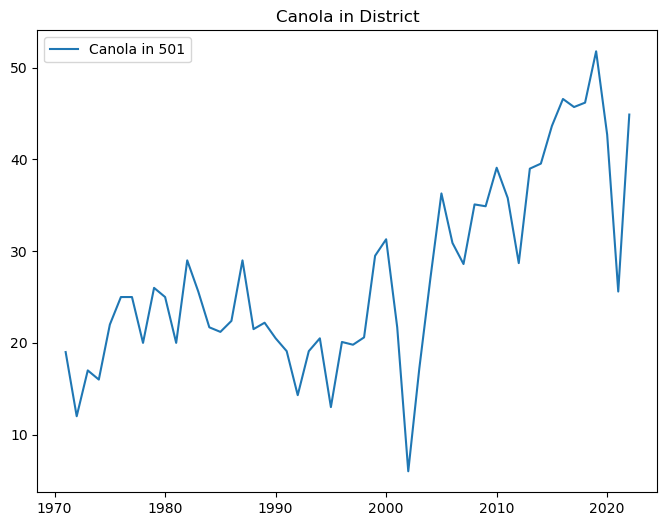

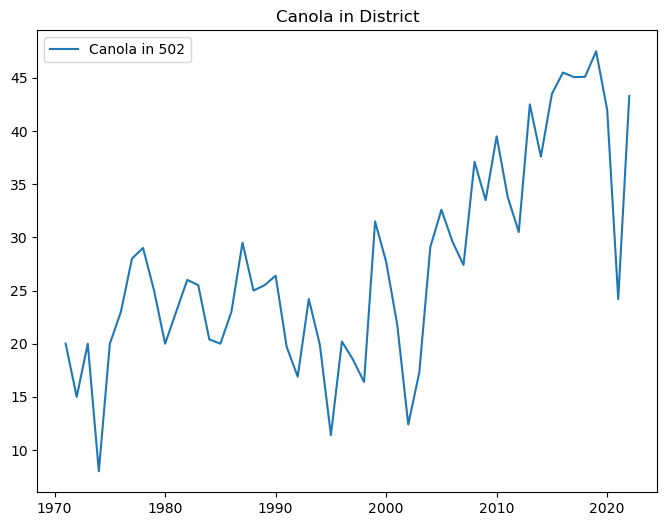

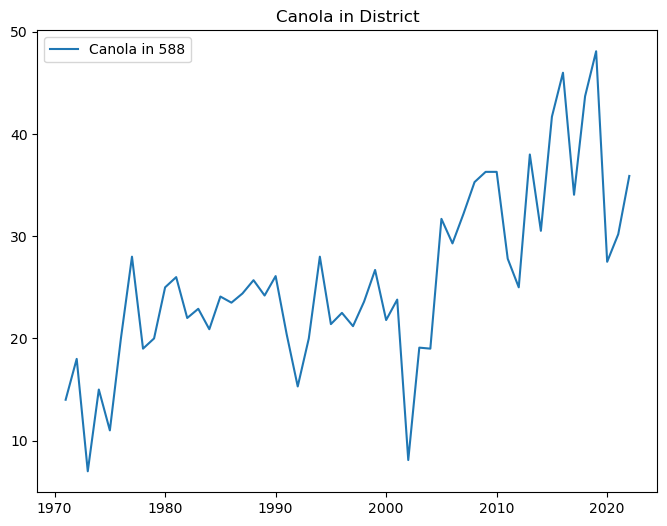

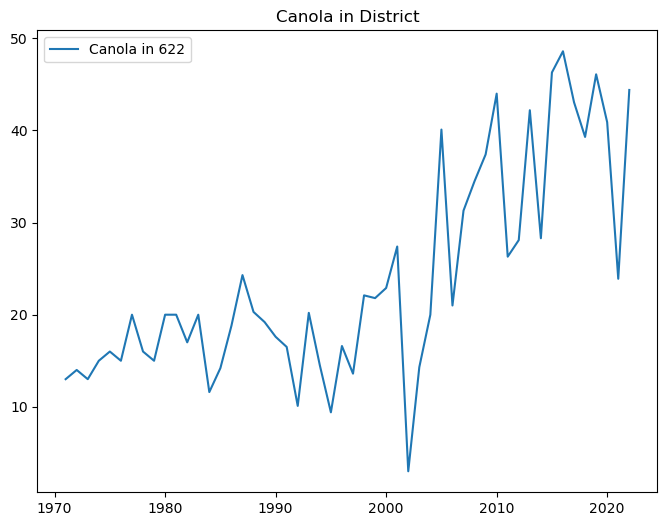

In [6]:
# plot the time series for every district
for district, district_canola in canola_filtered.groupby('RM'):
    
    plt.figure(figsize=(8, 6))
    plt.plot(district_canola['Canola'], label=f'Canola in {district}')
    plt.title('Canola in District')
    plt.legend()
    plt.show()

## De-Trending

<YearEnd: month=12>


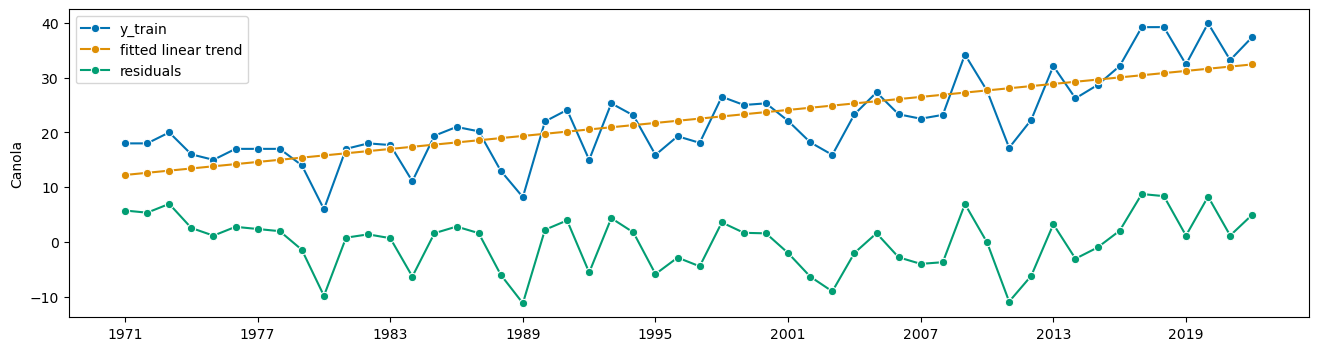

In [7]:
canola_dist1 = canola_filtered[canola_filtered['RM'] == 1]

canola_dist1.index = canola_dist1.index.to_period('A')

#change frequency 
frequency = canola_dist1.index.freq

print(frequency)

#print(canola_dist1)

# linear detrending
forecaster = PolynomialTrendForecaster(degree=1)
transformer = Detrender(forecaster=forecaster)
yt = transformer.fit_transform(canola_dist1['Canola'])


forecaster = PolynomialTrendForecaster(degree=1)
fh_ins = -np.arange(len(canola_dist1['Canola'])) 
y_pred = forecaster.fit(canola_dist1['Canola']).predict(fh=fh_ins)

plot_series(canola_dist1['Canola'], y_pred, yt, labels=["y_train", "fitted linear trend", "residuals"]);

## ARIMA

### Parameter Determination

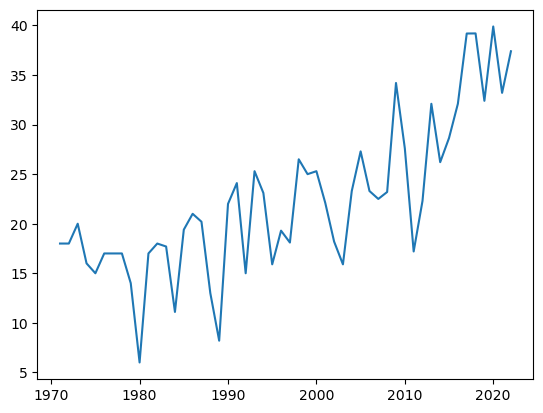

ADF Statistic: 1.5479283723232604
p-value: 0.9976926349856662
ADF Statistic: -3.9704253489575065
p-value: 0.001573541015475178


C:\Users\lplod\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


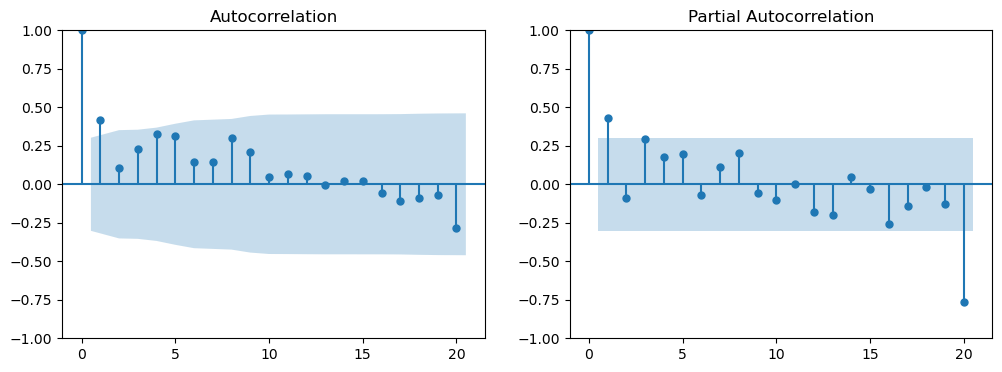

In [5]:
# Arima model for one time series 

canola_dist1 = canola_filtered[canola_filtered['RM'] == 1]

plt.plot(canola_dist1['Canola'])
plt.show()

test_set = canola_dist1.iloc[-10:]

# The training set is the rest of the data
training_set = canola_dist1.iloc[:-10]

training_set = training_set.asfreq("AS-JAN")

#plt.plot(training_set['Canola'])
#plt.show()

#check for stationarity with Augmented Dickey-Fuller (ADF) test 
result = adfuller(canola_dist1['Canola'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

result = adfuller(training_set['Canola'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# training set is stationary, whole data set is not, ???
# d = 0 

#check Autocorrelation and Partial Autocorrelation

# ACF and PACF plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(training_set['Canola'], lags=20, ax=ax1) # p = 1
plot_pacf(training_set['Canola'], lags=20, ax=ax2) # q = 1

plt.show()


## De-Trending

C:\Users\lplod\AppData\Local\Temp\ipykernel_25736\3418476542.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canola_dist1['detrended'] = canola_dist1['Canola'].rolling(window=window_size).mean()


<AxesSubplot:xlabel='Year'>

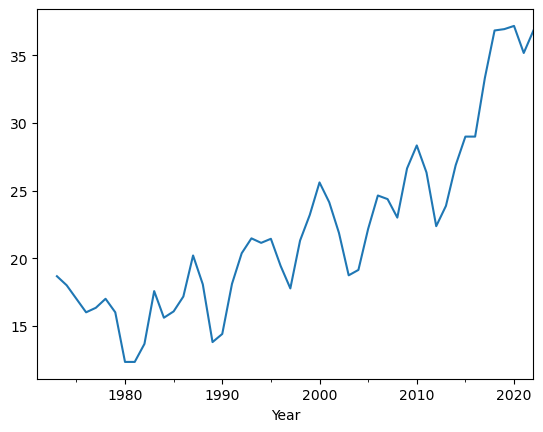

In [6]:
# simple moving average
window_size = 3
canola_dist1['detrended'] = canola_dist1['Canola'].rolling(window=window_size).mean()
canola_dist1['detrended'].plot()

## Decomposition

In [7]:
# decomposition = STL(canola_dist1['Canola'], seasonal=None)
# result_dec = decomposition.fit()
# canola_dist1['decomp'] = result_dec.trend 

# ValueError: period must be a positive integer >= 2

## Differencing

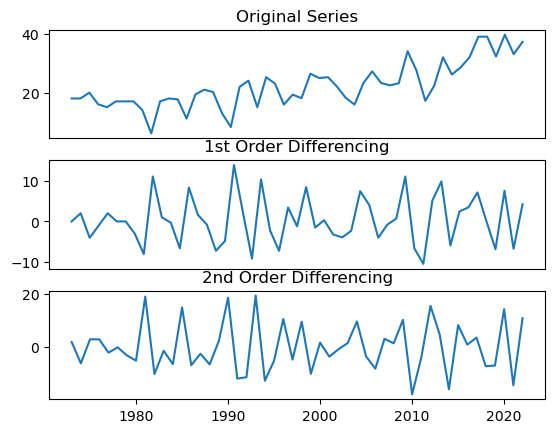

In [8]:
# Differencing Orders (confirms that d is likely 0)
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(canola_dist1.Canola); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(canola_dist1.Canola.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(canola_dist1.Canola.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

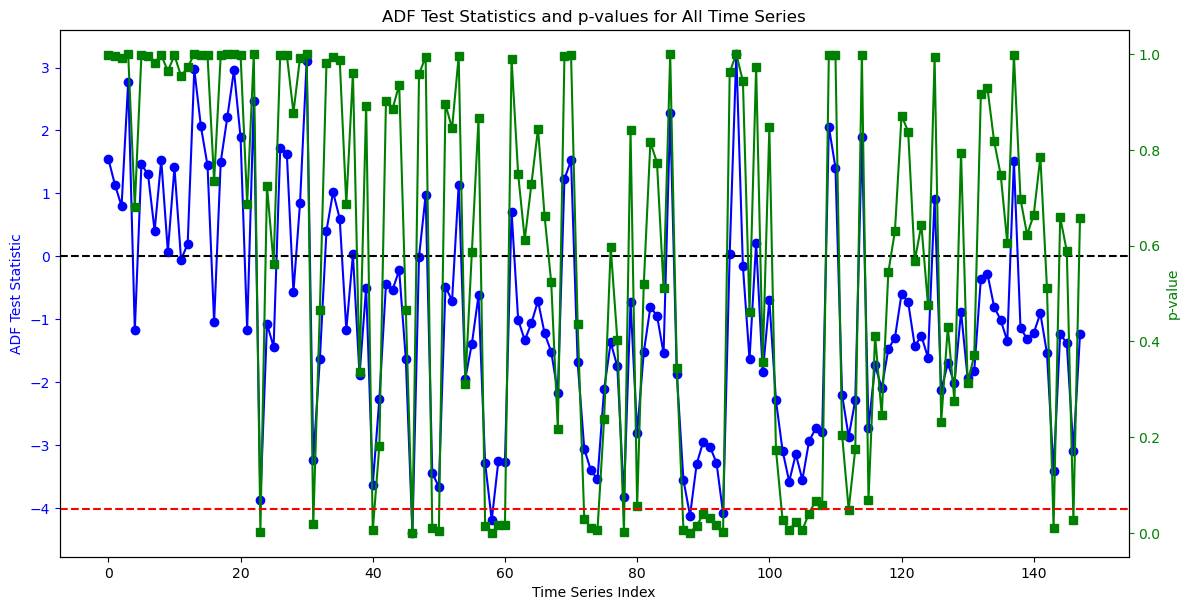

In [9]:
# problem: training set not entirely representative of test set in terms of stationarity

# Group by the 'RM' column
grouped_canola = canola_filtered.groupby('RM')

# Create empty lists to store ADF test statistics and p-values
adf_test_statistics = []
adf_p_values = []

# Loop through each group
for group_name, group_data in grouped_canola:
    # Perform ADF test
    result = adfuller(group_data['Canola'])
    
    # Store ADF test statistic and p-value in the lists
    adf_test_statistics.append(result[0])
    adf_p_values.append(result[1])
    
# Plot ADF test statistics and p-values
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(adf_test_statistics, marker='o', linestyle='-', color='blue', label='ADF Test Statistic')
ax1.set_xlabel('Time Series Index')
ax1.set_ylabel('ADF Test Statistic', color='blue')
ax1.tick_params('y', colors='blue')
ax1.axhline(y=0, color='black', linestyle='--')

ax2 = ax1.twinx()
ax2.plot(adf_p_values, marker='s', linestyle='-', color='green', label='p-value')
ax2.set_ylabel('p-value', color='green')
ax2.tick_params('y', colors='green')
ax2.axhline(y=0.05, color='red', linestyle='--', label='Significance Level (0.05)')

fig.tight_layout()
plt.title('ADF Test Statistics and p-values for All Time Series')
plt.show()

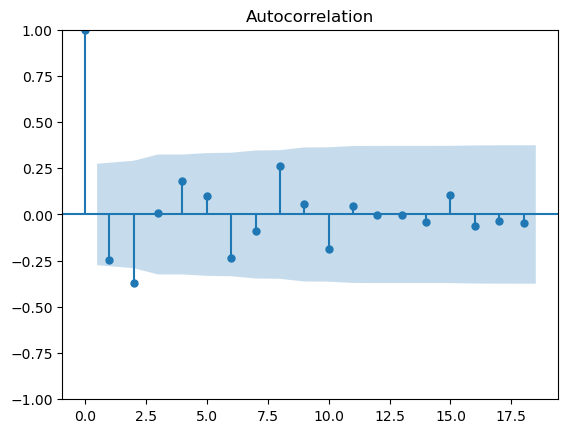

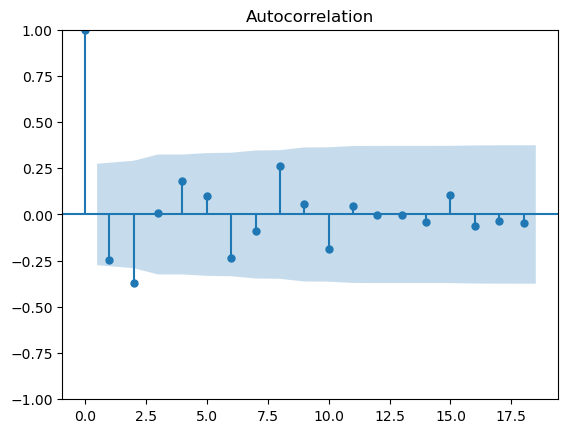

In [10]:
plot_acf(canola_dist1.Canola.diff().dropna()) # q = 1

C:\Users\lplod\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


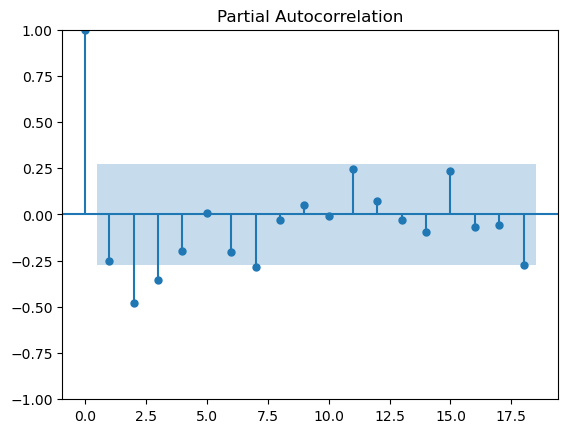

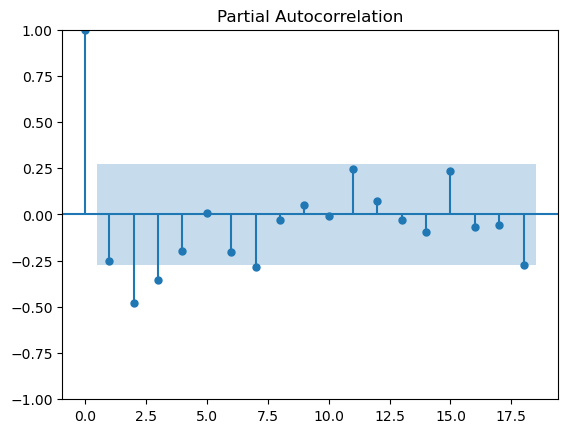

In [11]:
plot_pacf(canola_dist1.Canola.diff().dropna()) # d = 1,  p = 2?

                               SARIMAX Results                                
Dep. Variable:                 Canola   No. Observations:                   42
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -123.138
Date:                Mon, 27 Nov 2023   AIC                            250.275
Time:                        15:18:34   BIC                            253.702
Sample:                    01-01-1971   HQIC                           251.523
                         - 01-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8045      0.106     -7.591      0.000      -1.012      -0.597
sigma2        23.1829      5.550      4.177      0.000      12.305      34.060
Ljung-Box (L1) (Q):                   0.61   Jarque-

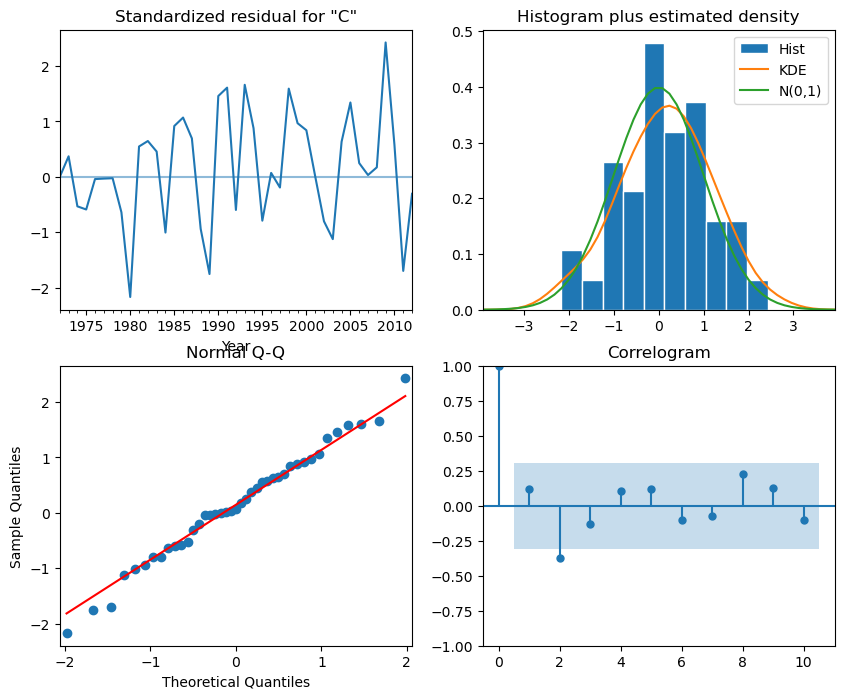

In [12]:
#fit model 

p, d, q = (0, 1, 1)
model = ARIMA(training_set['Canola'], order=(p, d, q), freq = "AS-JAN")
results = model.fit()

# Print model summary
print(results.summary())

# Plot diagnostics
results.plot_diagnostics(figsize=(10, 8))
plt.show()

# Seems ok?


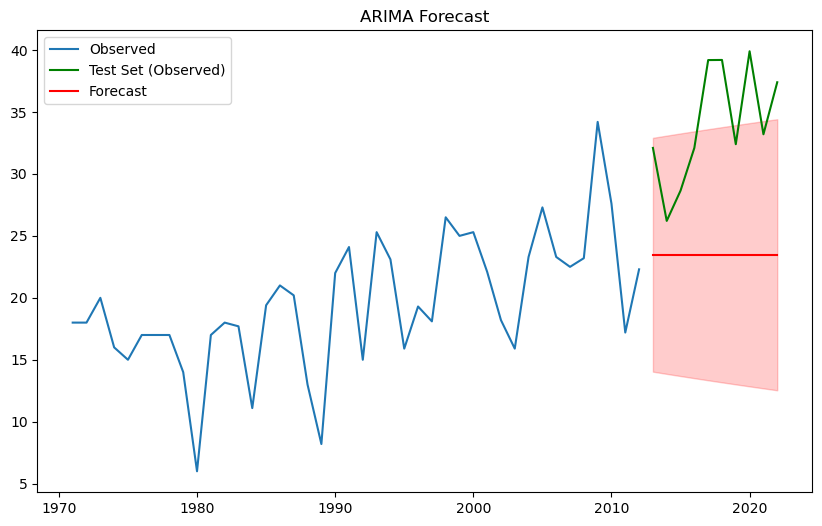

In [13]:
#forecastingt 

forecast_steps = 10 
forecast = results.get_forecast(steps=forecast_steps)
forecast_ci = forecast.conf_int()

#print(training_set.index)
#print(forecast.predicted_mean.index)

forecast_start_date = training_set.index[-1] + pd.DateOffset(years=1)
forecast_end_date = forecast.predicted_mean.index[-1]
full_index = pd.date_range(start=training_set.index[0], end=forecast_end_date, freq='AS-JAN')
forecast.predicted_mean = forecast.predicted_mean.reindex(full_index, fill_value=None)


#print(training_set.index.freq)
#print(forecast.predicted_mean.index.freq)

plt.figure(figsize=(10, 6))
plt.plot(training_set['Canola'], label='Observed')
plt.plot(test_set.index, test_set['Canola'], label='Test Set (Observed)', color='green')
plt.plot(forecast.predicted_mean, color='red', label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='red', alpha=0.2)
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

C:\Users\lplod\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                 Canola   No. Observations:                   42
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -128.250
Date:                Mon, 27 Nov 2023   AIC                            262.499
Time:                        15:18:35   BIC                            267.566
Sample:                    01-01-1971   HQIC                           264.331
                         - 01-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1995      0.169     -1.183      0.237      -0.530       0.131
ma.L1         -0.9992     12.854     -0.078      0.938     -26.192      24.194
sigma2        32.2223    413.151      0.078      0.9

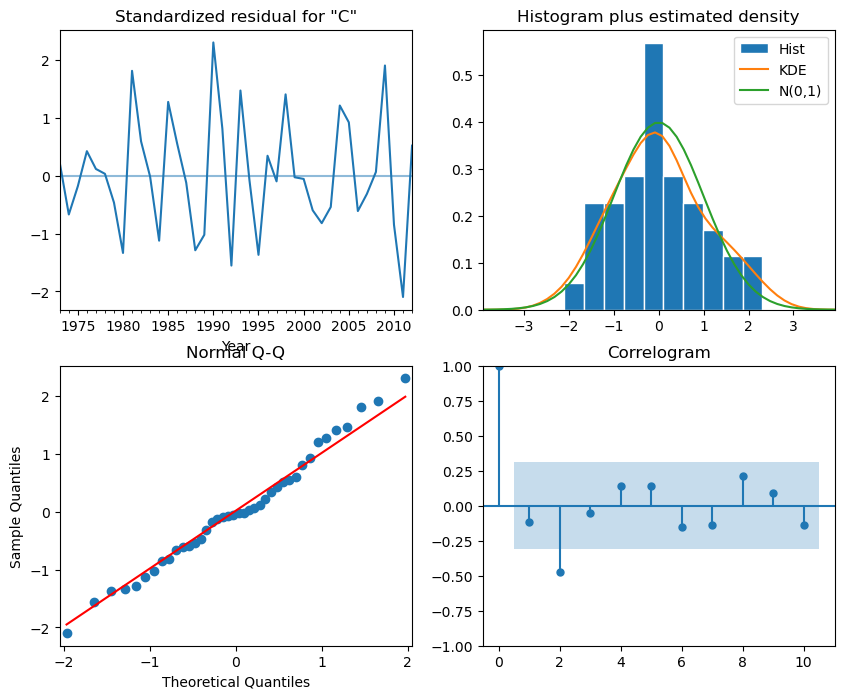

In [14]:
#fit model 2

p2, d2, q2 = (1, 2, 1)
model2 = ARIMA(training_set['Canola'], order=(p2, d2, q2), freq = "AS-JAN")
results2 = model2.fit()

# Print model summary
print(results2.summary())

# Plot diagnostics
results2.plot_diagnostics(figsize=(10, 8))
plt.show()

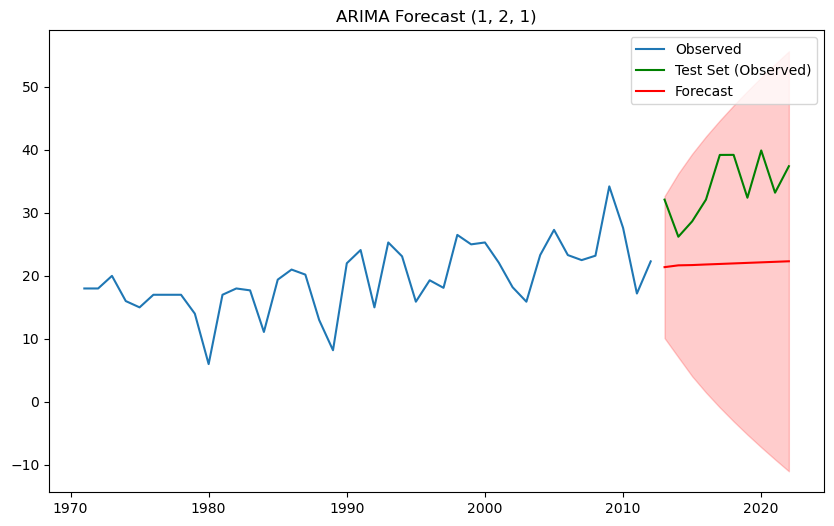

In [15]:
forecast2 = results2.get_forecast(steps=forecast_steps)
forecast2_ci = forecast2.conf_int()

forecast2_start_date = training_set.index[-1] + pd.DateOffset(years=1)
forecast2_end_date = forecast2.predicted_mean.index[-1]
full_index = pd.date_range(start=training_set.index[0], end=forecast2_end_date, freq='AS-JAN')
forecast2.predicted_mean = forecast2.predicted_mean.reindex(full_index, fill_value=None)


#print(training_set.index.freq)
#print(forecast.predicted_mean.index.freq)

plt.figure(figsize=(10, 6))
plt.plot(training_set['Canola'], label='Observed')
plt.plot(test_set.index, test_set['Canola'], label='Test Set (Observed)', color='green')
plt.plot(forecast2.predicted_mean, color='red', label='Forecast')
plt.fill_between(forecast2_ci.index, forecast2_ci.iloc[:, 0], forecast2_ci.iloc[:, 1], color='red', alpha=0.2)
plt.title('ARIMA Forecast (1, 2, 1)')
plt.legend()
plt.show()

## Exponential Smoothing

### Hyperparameter Determination

In [16]:
alpha_star = None
best_mse = None
dat = canola_dist1.iloc[:, :].values.astype('float32')
mean_results_for_all_possible_alpha_values = np.zeros(9)
for alpha in range(0, 9):
    pt = np.mean(dat[:, 0][0:5])
    mean_for_alpha = np.zeros(len(dat))
    mean_for_alpha[0] = np.power(dat[0][0] - pt, 2)
    for i in range(1, len(dat)):
        pt = pt + ((alpha + 1) * 0.1) * (dat[i - 1][0] - pt)
        mean_for_alpha[i] = np.power(dat[i][0] - pt, 2)
    mean_results_for_all_possible_alpha_values[alpha] = np.mean(mean_for_alpha)
alpha_star = (np.argmin(mean_results_for_all_possible_alpha_values) + 1) * 0.1
best_mse = np.min(mean_results_for_all_possible_alpha_values)
print("Best MSE = %s" % best_mse)
print("Optimal alpha = %s" % alpha_star)

Best MSE = 0.0
Optimal alpha = 0.1


### Simple Exponential Smoothing

In [17]:
model3 = SimpleExpSmoothing(training_set['Canola'])
model3_fit = model3.fit(smoothing_level=0.1,optimized=False)
model3_fit.params
y_hat_ses = test_set.copy()
y_hat_ses['ses_forecast'] = model3_fit.forecast(len(test_set))

print(y_hat_ses['ses_forecast'])

Year
2013-01-01    22.554573
2014-01-01    22.554573
2015-01-01    22.554573
2016-01-01    22.554573
2017-01-01    22.554573
2018-01-01    22.554573
2019-01-01    22.554573
2020-01-01    22.554573
2021-01-01    22.554573
2022-01-01    22.554573
Name: ses_forecast, dtype: float64


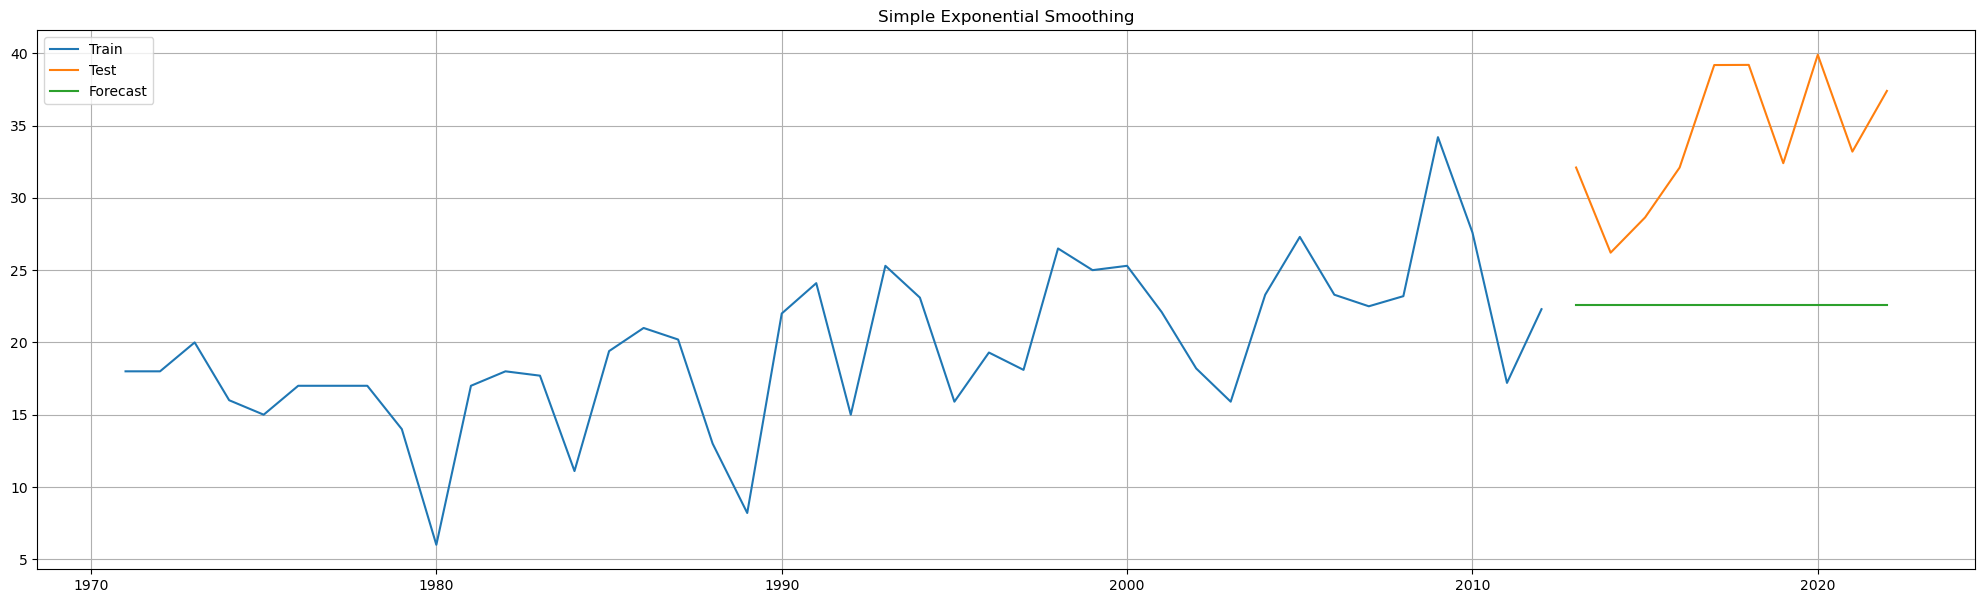

In [18]:
plt.figure(figsize=(25,7))
plt.grid()
plt.plot(training_set['Canola'], label='Train')
plt.plot(test_set['Canola'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing')
plt.show()

### Holt-Winters Exponential Smoothing

In [19]:
model4 = ExponentialSmoothing(np.asarray(training_set['Canola']),trend='multiplicative', seasonal=None)
model4_fit = model4.fit(smoothing_level=0.5, smoothing_slope=0.01, optimized=False) # to be optimized
print(model4_fit.params)
y_hat_holt = test_set.copy()
y_hat_holt['holt_forecast'] = model4_fit.forecast(len(test_set))

{'smoothing_level': 0.5, 'smoothing_trend': 0.01, 'smoothing_seasonal': None, 'damping_trend': nan, 'initial_level': 20.666666666666657, 'initial_trend': 0.9571847507331379, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


C:\Users\lplod\AppData\Local\Temp\ipykernel_25736\2100274245.py:2: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  model4_fit = model4.fit(smoothing_level=0.5, smoothing_slope=0.01, optimized=False) # to be optimized


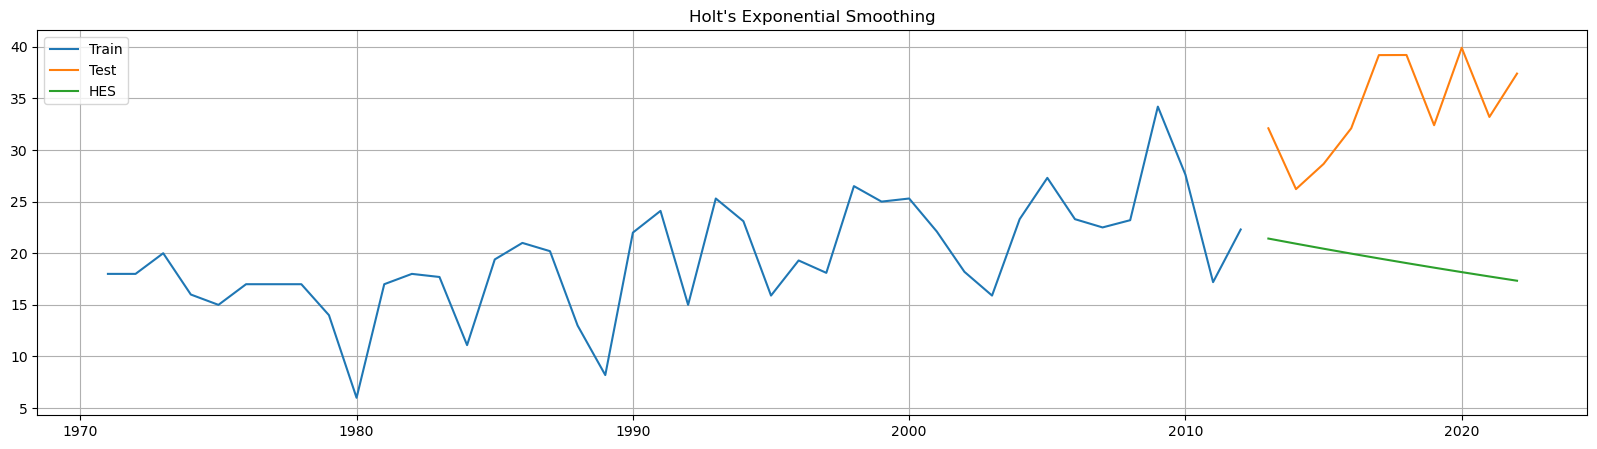

In [20]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot( training_set['Canola'], label='Train')
plt.plot(test_set['Canola'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='HES')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing')
plt.show()

## Prophet

In [21]:
model5 = Prophet()
model5.fit(training_set['Canola'])
future5 = model5.make_future_dataframe(periods= 10)
forecast5 = model5.predict(future5)
fig = model5.plot(forecast5, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')
a = add_changepoints_to_plot(fig.gca(), model5, forecast5)

NameError: name 'Prophet' is not defined

## Backlog

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

canola.plot(ax=ax)
canola.plot(style='k.', alpha=0.3, ax=ax)

plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 11))

canola.plot(ax=axes[0])
axes[0].set_title('Line Plot')

canola.plot(style='k.', ax=axes[1])
axes[1].set_title('Scatter Plot')

plt.tight_layout() # improve spacing

plt.show()

In [ ]:
# QUESTIONS MOVING FORWARD

## How are we going to address outliers? Do we drop the zeros (are they credible or just lack of reporting); high values?
## Seasonal Decomposition -> how detailed, in what regards?
## what libraries for model building? Any preferences, common in-house practices, recent new developments etc.?

## homogeneity between all the time series? Cluster, Geodaten(districts)? ANOVA? 
## missing values, interpolate? 
## Decompose into trend, seasonality(?), residuals
## Stationality? -> ARIMA 


In [ ]:
#groups = canola.groupby(pd.Grouper(freq='A'))